# アミノ酸配列のグラフ表示画像のVision Transformerによるタンパク質ファミリー分類（5分割交差検証）
- データセット：`InterPro/GPCR`
- グラデーション適用
- クラスごとに分ける `StratifiedKFold` を採用
- ベースモデル：`google/vit-base-patch16-224-in21k`
- ハイパーパラメータ
    - バッチサイズ：$16$
    - エポック数：$10$
    - 学習率：$5 \times 10^{-5}$

## 1. ライブラリのインポート

In [1]:
from torch.utils.data import Dataset, Subset
from PIL import Image
import os
import pandas as pd
import numpy as np

from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import ViTImageProcessorFast, ViTForImageClassification, ViTConfig, TrainingArguments, Trainer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import evaluate

label2id = {
    "IPR000018": 0,
    "IPR000025": 1,
    "IPR000142": 2,
    "IPR000204": 3,
    "IPR000356": 4,
    "IPR000371": 5,
    "IPR000405": 6,
    "IPR000499": 7,
    "IPR000503": 8,
    "IPR000586": 9,
    "IPR000611": 10,
    "IPR000670": 11,
    "IPR000723": 12,
    "IPR000725": 13,
    "IPR000820": 14,
    "IPR000826": 15,
    "IPR000921": 16,
    "IPR000929": 17,
    "IPR000995": 18,
    "IPR001069": 19,
    "IPR001350": 20,
    "IPR001402": 21,
    "IPR001418": 22,
    "IPR001520": 23,
    "IPR001556": 24,
    "IPR001634": 25,
    "IPR001658": 26,
    "IPR001671": 27,
    "IPR001681": 28,
    "IPR001760": 29,
    "IPR001793": 30,
    "IPR001817": 31,
    "IPR001973": 32,
    "IPR002002": 33,
    "IPR002120": 34,
    "IPR002131": 35,
    "IPR002230": 36,
    "IPR002231": 37,
    "IPR002232": 38,
    "IPR002233": 39,
    "IPR002275": 40,
    "IPR002276": 41,
    "IPR002282": 42,
    "IPR002962": 43,
    "IPR003904": 44,
    "IPR003905": 45,
    "IPR003909": 46,
    "IPR003912": 47,
    "IPR003980": 48,
    "IPR003981": 49,
    "IPR003984": 50,
    "IPR004061": 51,
    "IPR004065": 52,
    "IPR004071": 53,
    "IPR005388": 54,
    "IPR005389": 55,
    "IPR005390": 56,
    "IPR005394": 57,
    "IPR005395": 58,
    "IPR005464": 59,
    "IPR005466": 60,
    "IPR008102": 61,
    "IPR008103": 62,
    "IPR008109": 63,
    "IPR008112": 64,
    "IPR008361": 65,
    "IPR008365": 66,
    "IPR009126": 67,
    "IPR009132": 68,
    "IPR009150": 69,
    "IPR013312": 70,
    "IPR022347": 71,
    "IPR026234": 72,
    "IPR027677": 73,
    "IPR028335": 74,
    "IPR028336": 75,
    "IPR037486": 76,
    "IPR039952": 77,
    "IPR042804": 78,
    "IPR047143": 79,
    "IPR047160": 80,
    "IPR048077": 81,
    "IPR049579": 82,
    "IPR050119": 83
}
id2label = {v: k for k, v in label2id.items()}

MODEL_NAME = "google/vit-base-patch16-224-in21k"
BATCH_SIZE = 16
EPOCHS = 10
LR = 5e-5
# WEIGHT_DECAY = 1e-4

## 1. 画像とラベルの対応を取る `Dataset` を作成

In [2]:
class GPCRImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path, header=None, names=["num", "label", "accession"])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['num']}.png")
        image = Image.open(img_path).convert("RGB")
        label = label2id[row["label"]]

        if self.transform:
            image = self.transform(image)
        return {"pixel_values": image, "label": label}

## 2. 画像前処理（ViT用）

In [3]:
processor = ViTImageProcessorFast.from_pretrained(MODEL_NAME)
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

## 3. `Trainer` を使って学習

In [4]:
accuracy = evaluate.load("accuracy")
dataset = GPCRImageDataset("../../../data/interpro-labels.csv", "../../../graphs/interpro", transform=transform)

# StratifiedKFoldはラベル情報を使う
labels = dataset.data["label"].values
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

[Fold 1 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_4386/742503592.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.9694 | Precision: 0.9319 | Recall: 0.9278 | F1: 0.9283
              precision    recall  f1-score       support
IPR000018      0.992308  0.941606  0.966292    137.000000
IPR000025      0.993464  0.980645  0.987013    620.000000
IPR000142      1.000000  0.993464  0.996721    153.000000
IPR000204      0.947867  0.900901  0.923788    222.000000
IPR000356      0.973684  0.982301  0.977974    113.000000
...                 ...       ...       ...           ...
IPR049579      1.000000  1.000000  1.000000    188.000000
IPR050119      0.962792  0.973362  0.968048   5556.000000
accuracy       0.969429  0.969429  0.969429      0.969429
macro avg      0.931864  0.927811  0.928297  84197.000000
weighted avg   0.970181  0.969429  0.969555  84197.000000

[87 rows x 4 columns]


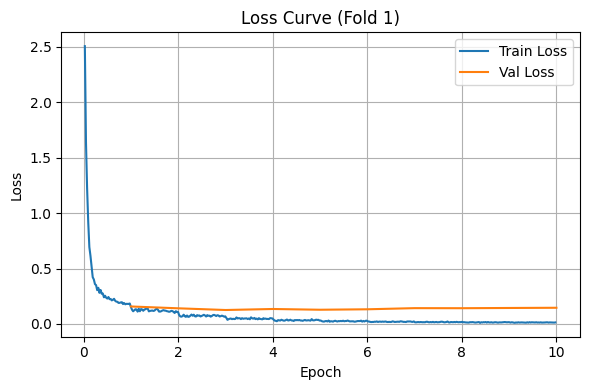

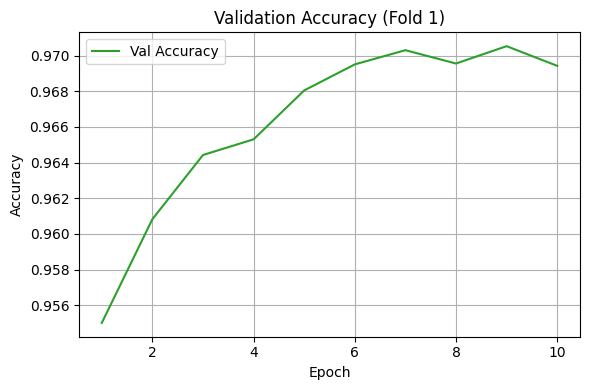

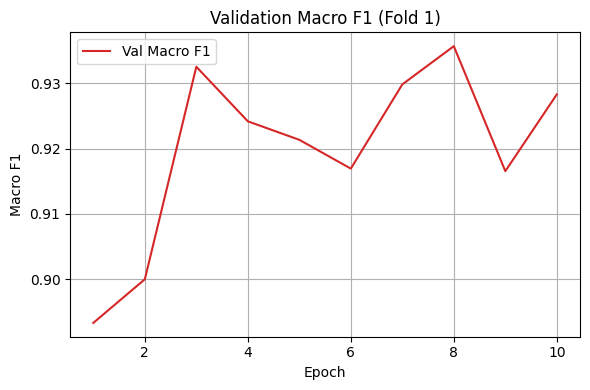

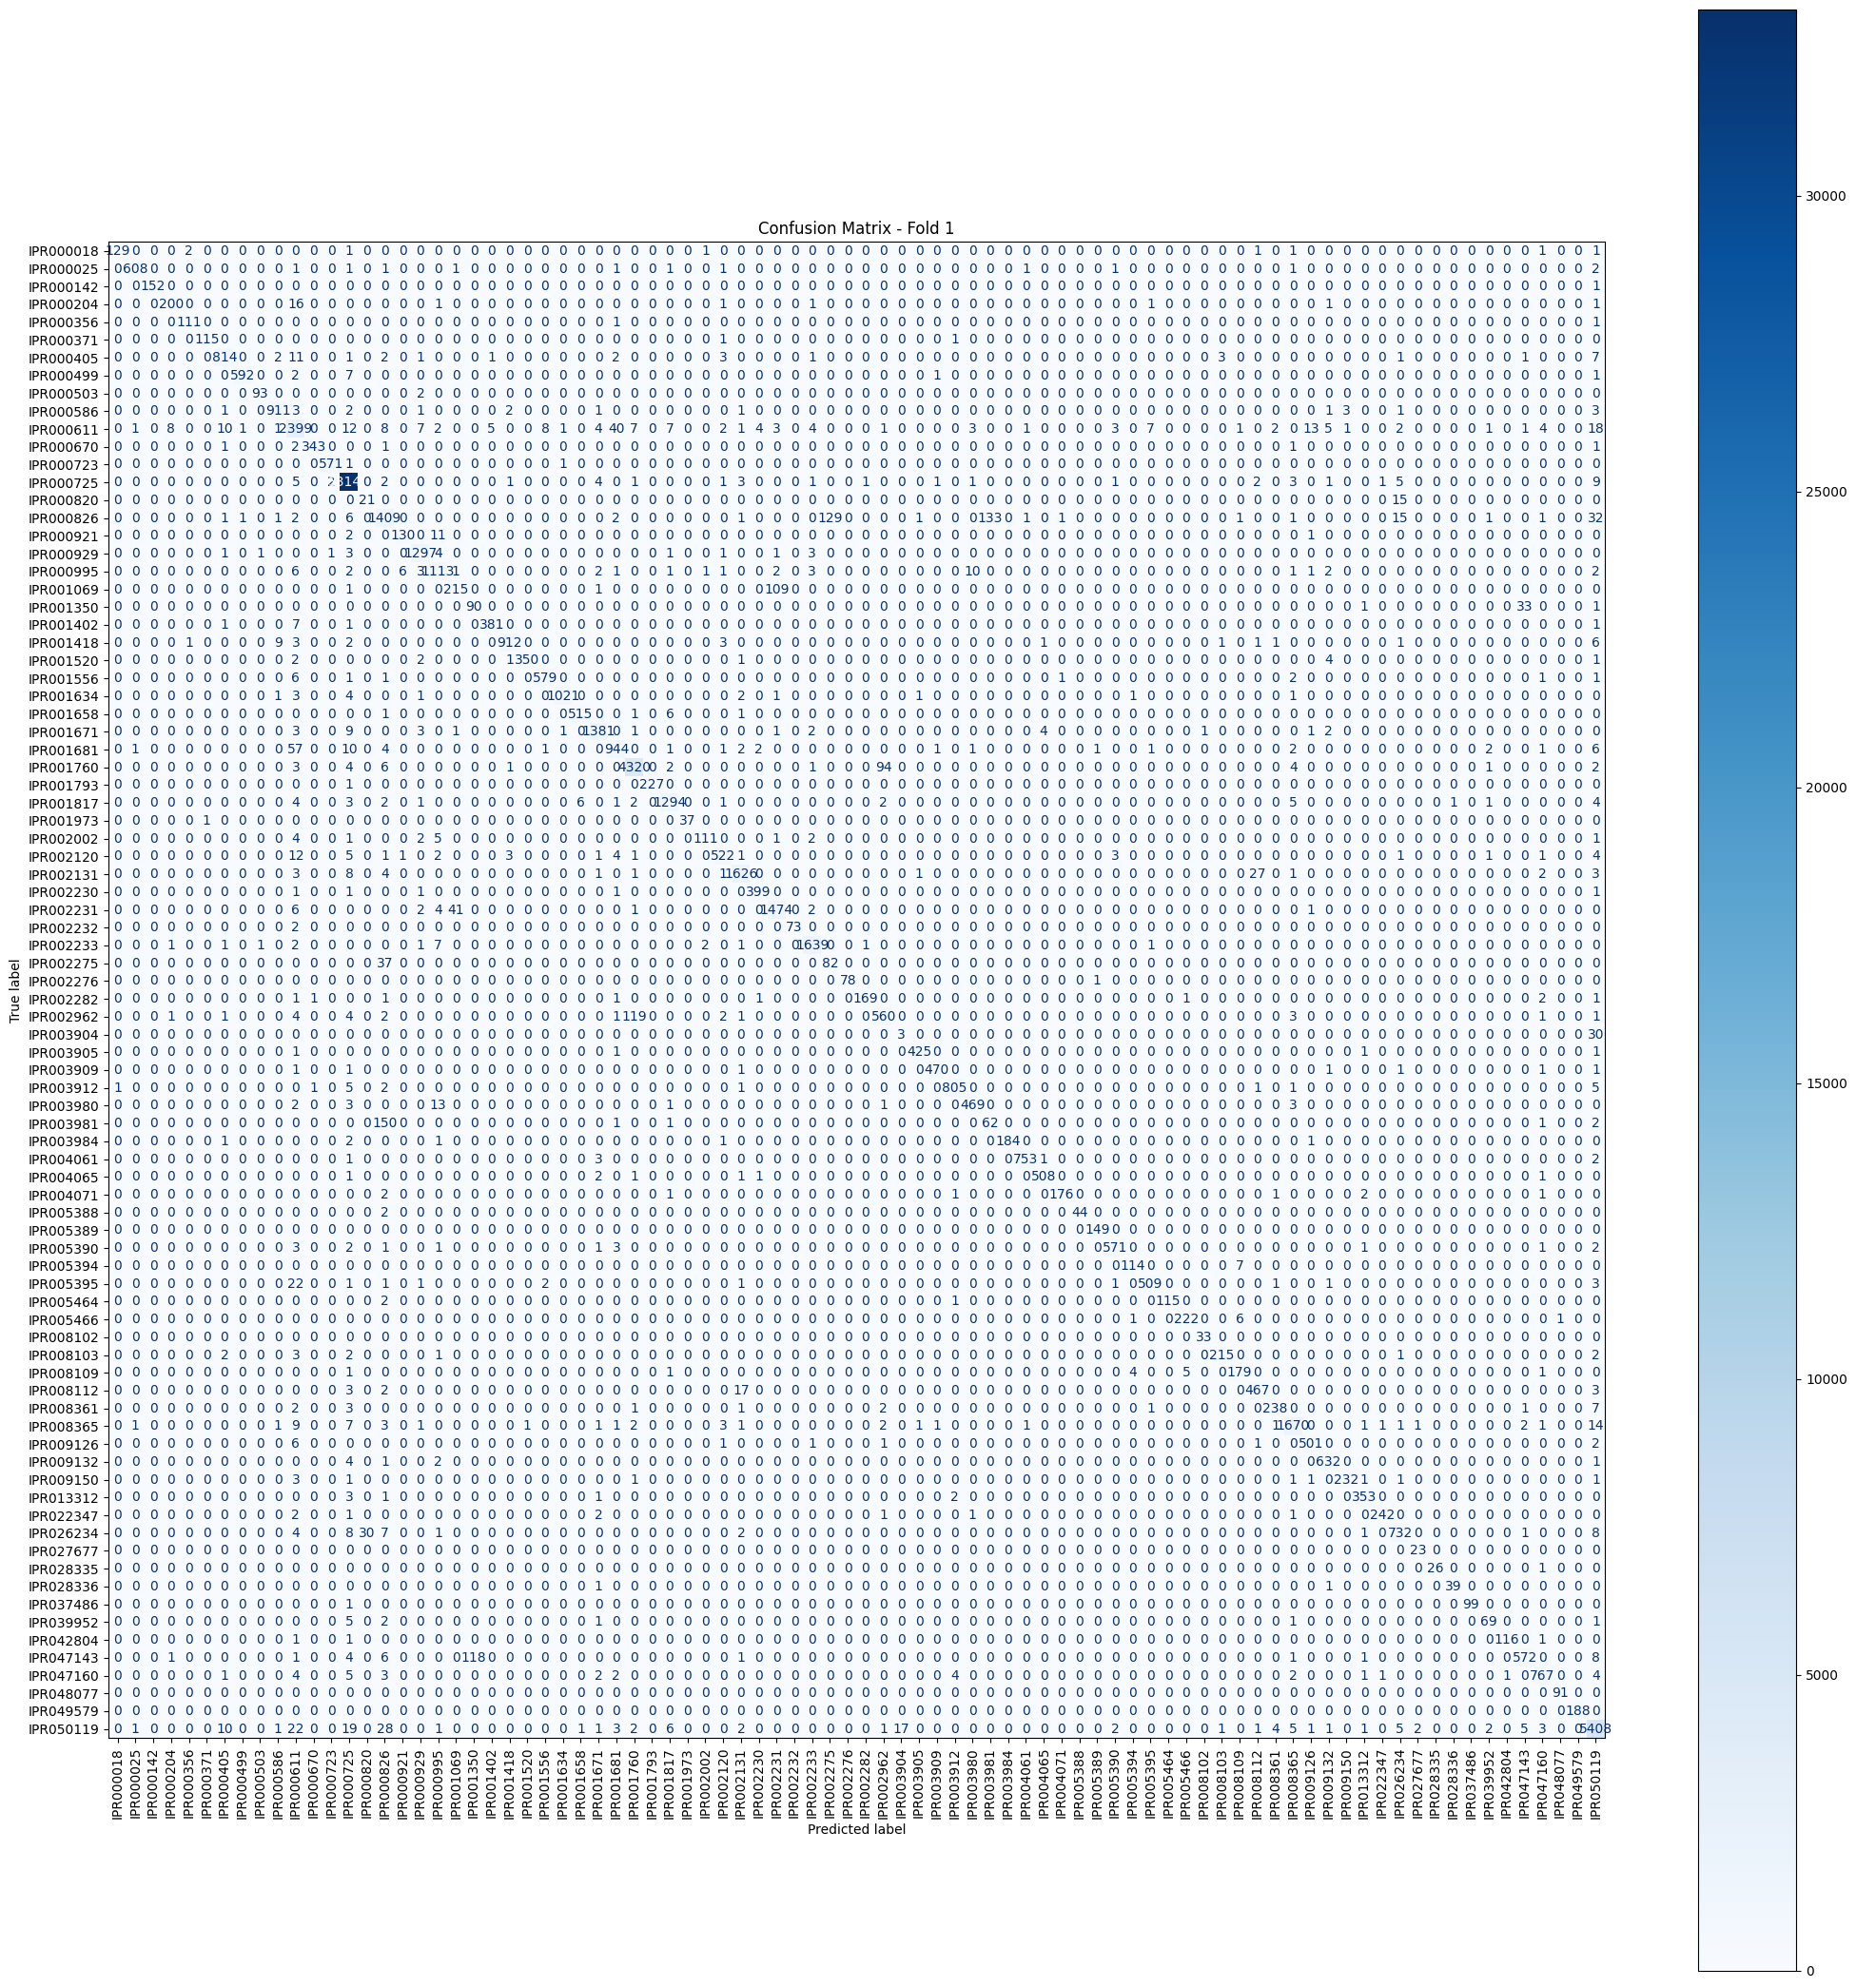

[Fold 2 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_4386/742503592.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.9696 | Precision: 0.9213 | Recall: 0.9101 | F1: 0.9151
              precision    recall  f1-score       support
IPR000018      0.992481  0.963504  0.977778    137.000000
IPR000025      0.993517  0.988710  0.991108    620.000000
IPR000142      0.993464  0.993464  0.993464    153.000000
IPR000204      0.937500  0.945946  0.941704    222.000000
IPR000356      0.973913  0.991150  0.982456    113.000000
...                 ...       ...       ...           ...
IPR049579      1.000000  0.989362  0.994652    188.000000
IPR050119      0.966465  0.975338  0.970881   5555.000000
accuracy       0.969619  0.969619  0.969619      0.969619
macro avg      0.921250  0.910089  0.915069  84196.000000
weighted avg   0.968438  0.969619  0.968875  84196.000000

[87 rows x 4 columns]


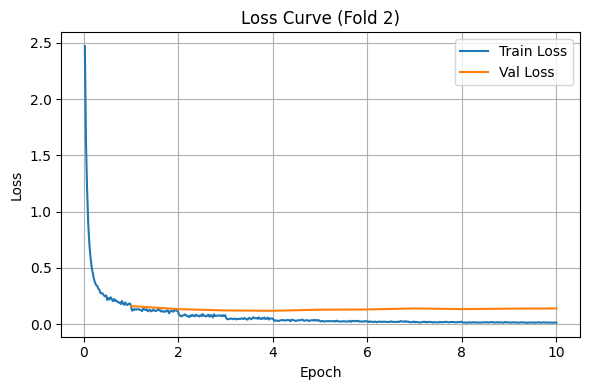

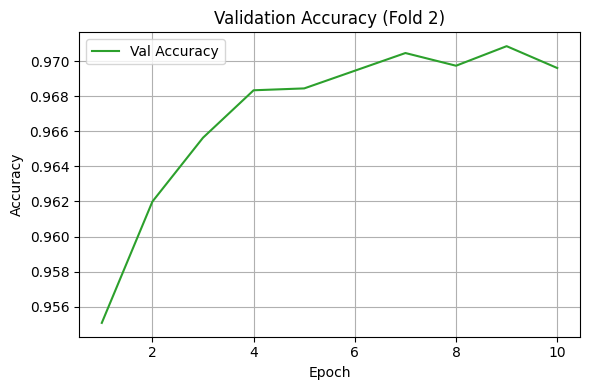

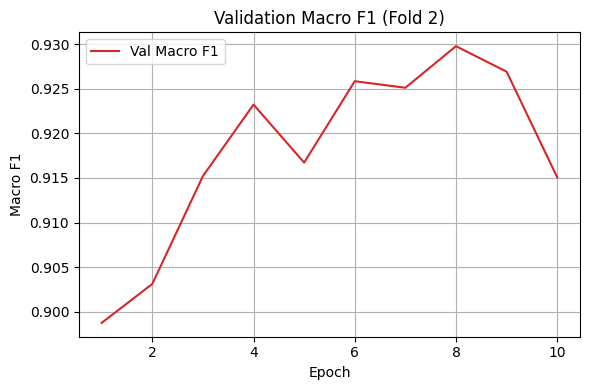

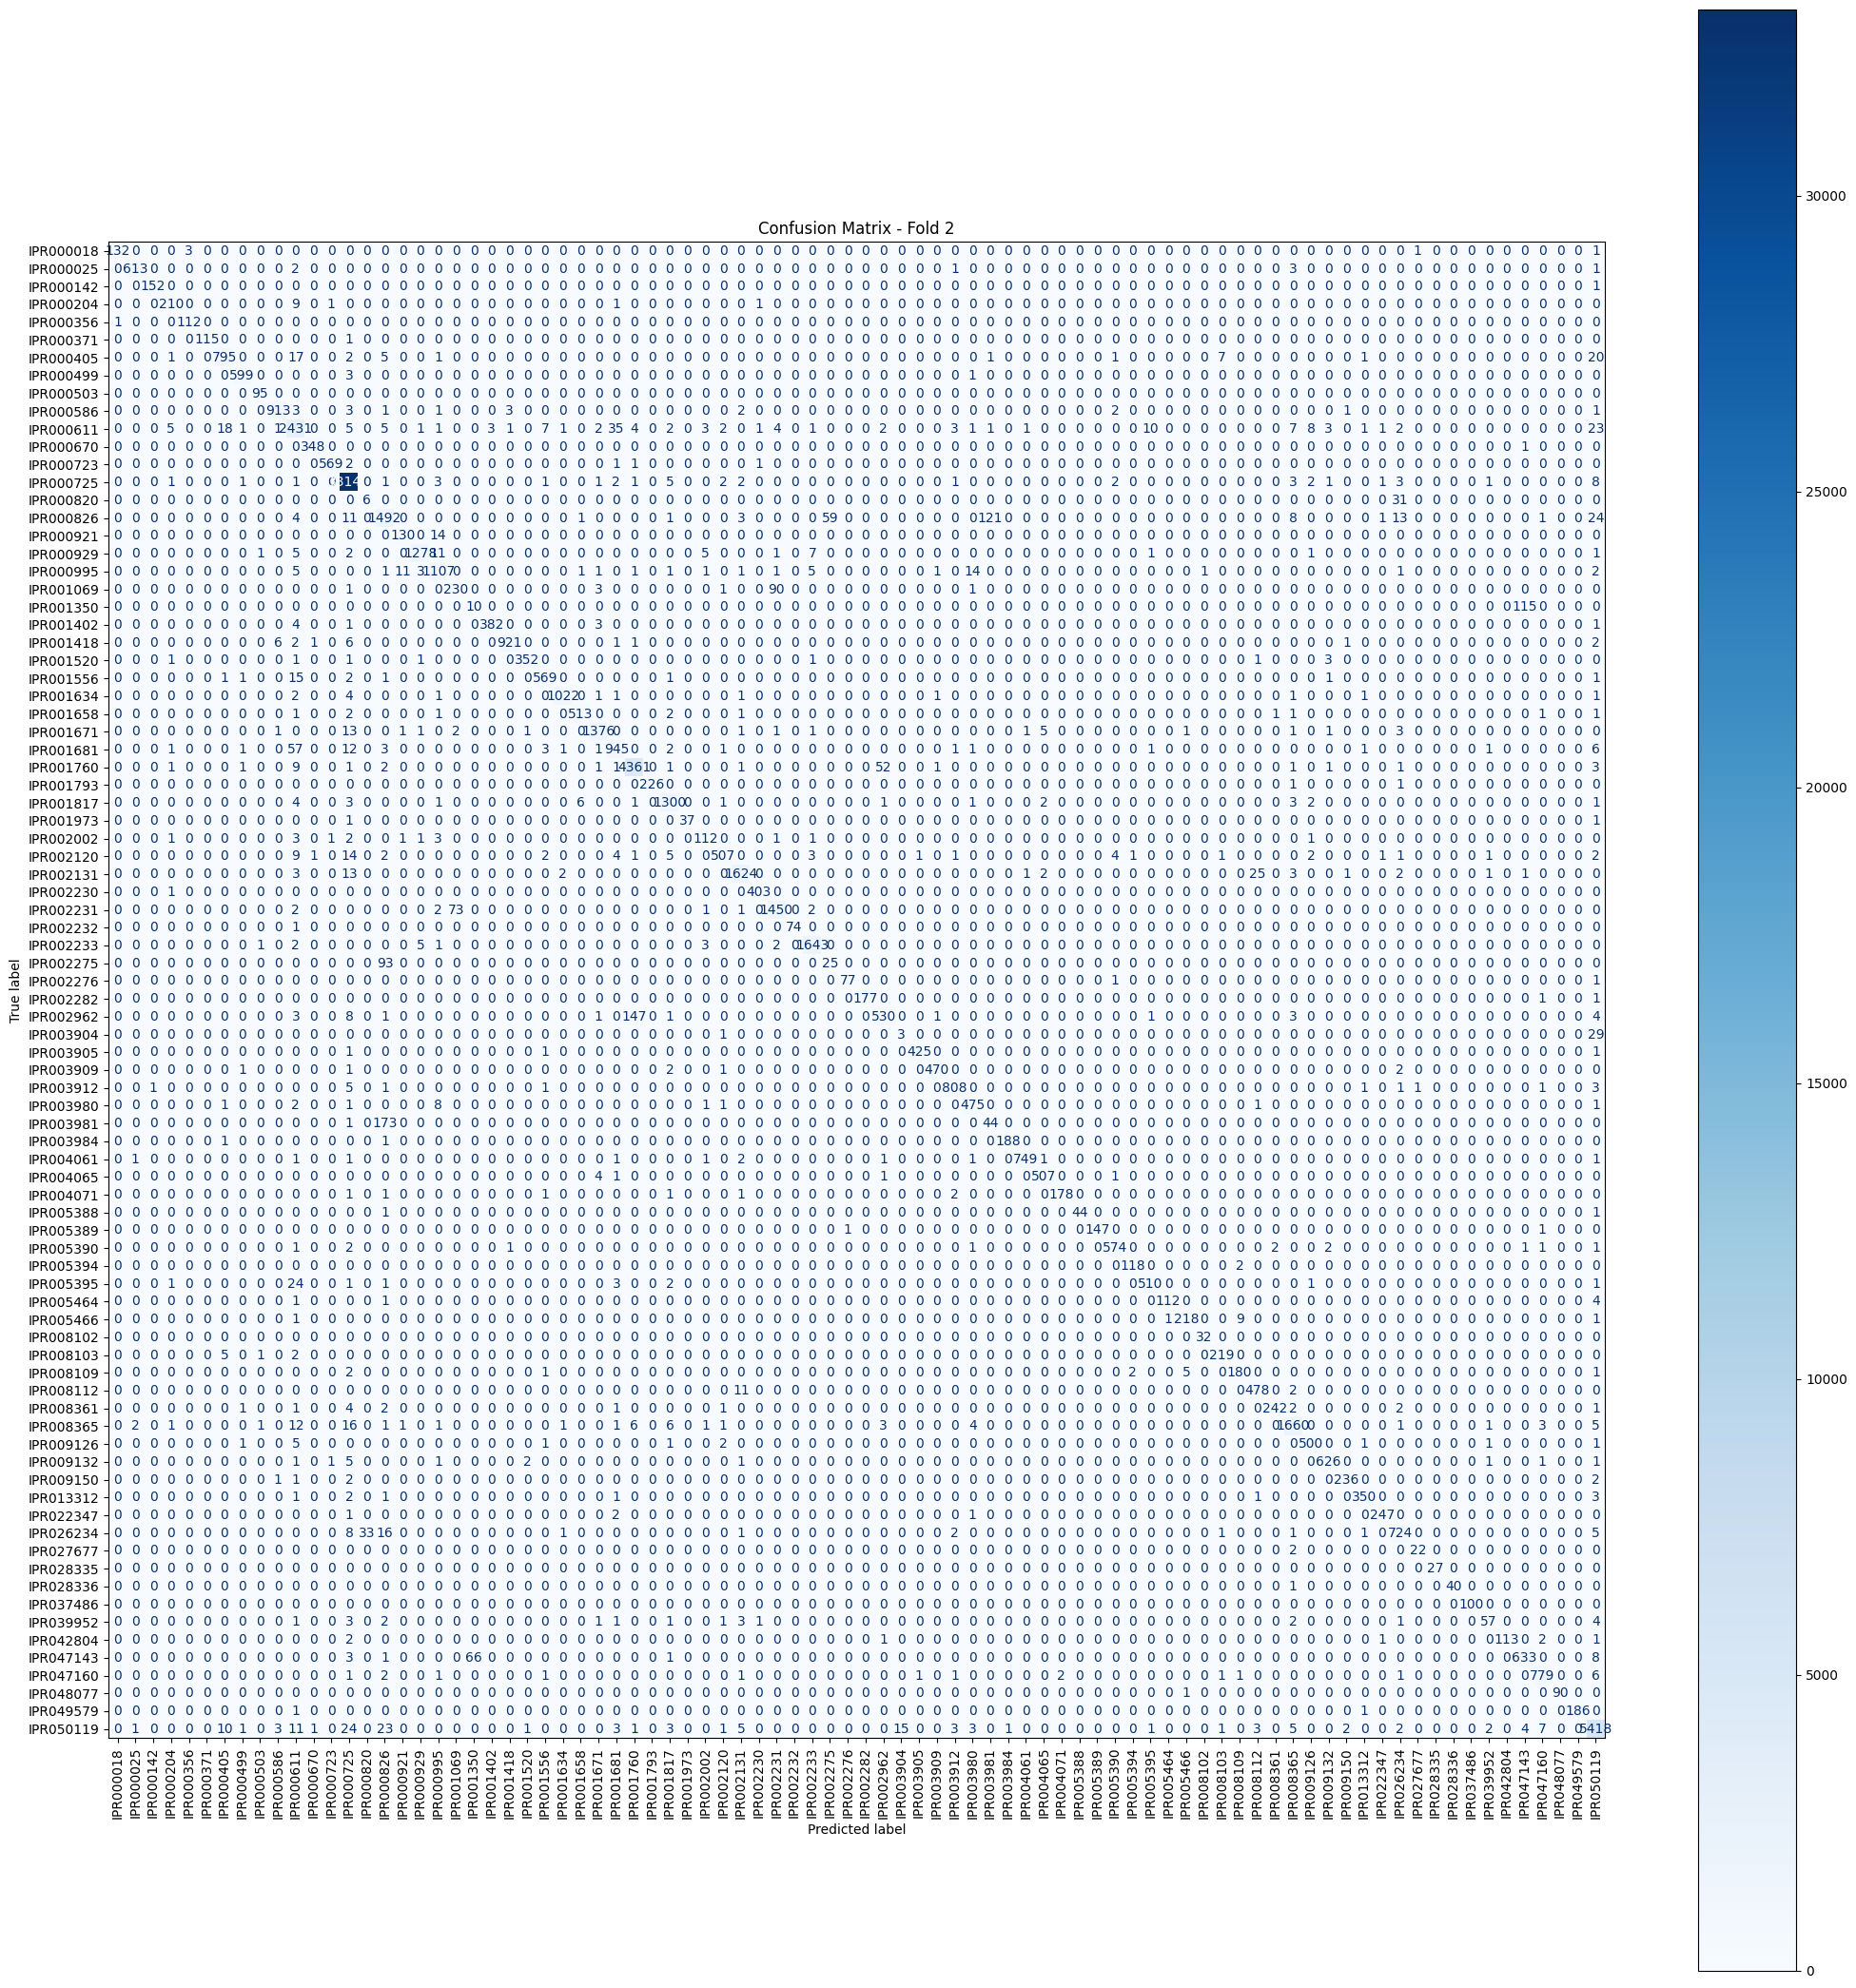

[Fold 3 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_4386/742503592.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.9691 | Precision: 0.9276 | Recall: 0.9239 | F1: 0.9245
              precision    recall  f1-score       support
IPR000018      1.000000  0.985401  0.992647    137.000000
IPR000025      1.000000  0.991935  0.995951    620.000000
IPR000142      1.000000  0.986842  0.993377    152.000000
IPR000204      0.948598  0.914414  0.931193    222.000000
IPR000356      1.000000  0.982456  0.991150    114.000000
...                 ...       ...       ...           ...
IPR049579      1.000000  0.989305  0.994624    187.000000
IPR050119      0.954784  0.980562  0.967501   5556.000000
accuracy       0.969132  0.969132  0.969132      0.969132
macro avg      0.927607  0.923860  0.924482  84196.000000
weighted avg   0.969440  0.969132  0.969135  84196.000000

[87 rows x 4 columns]


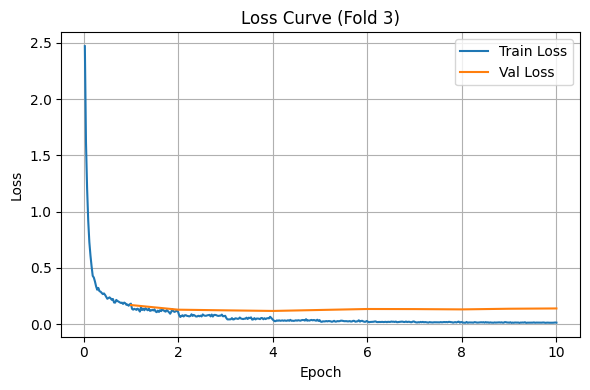

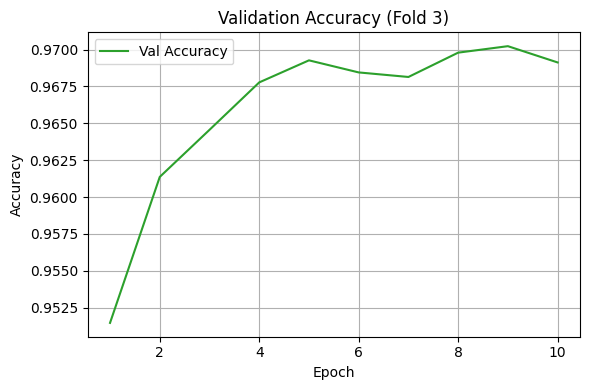

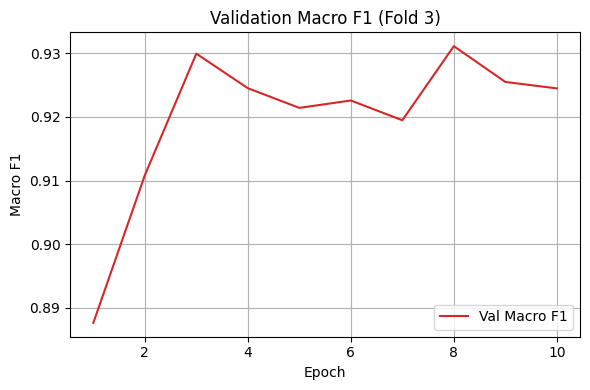

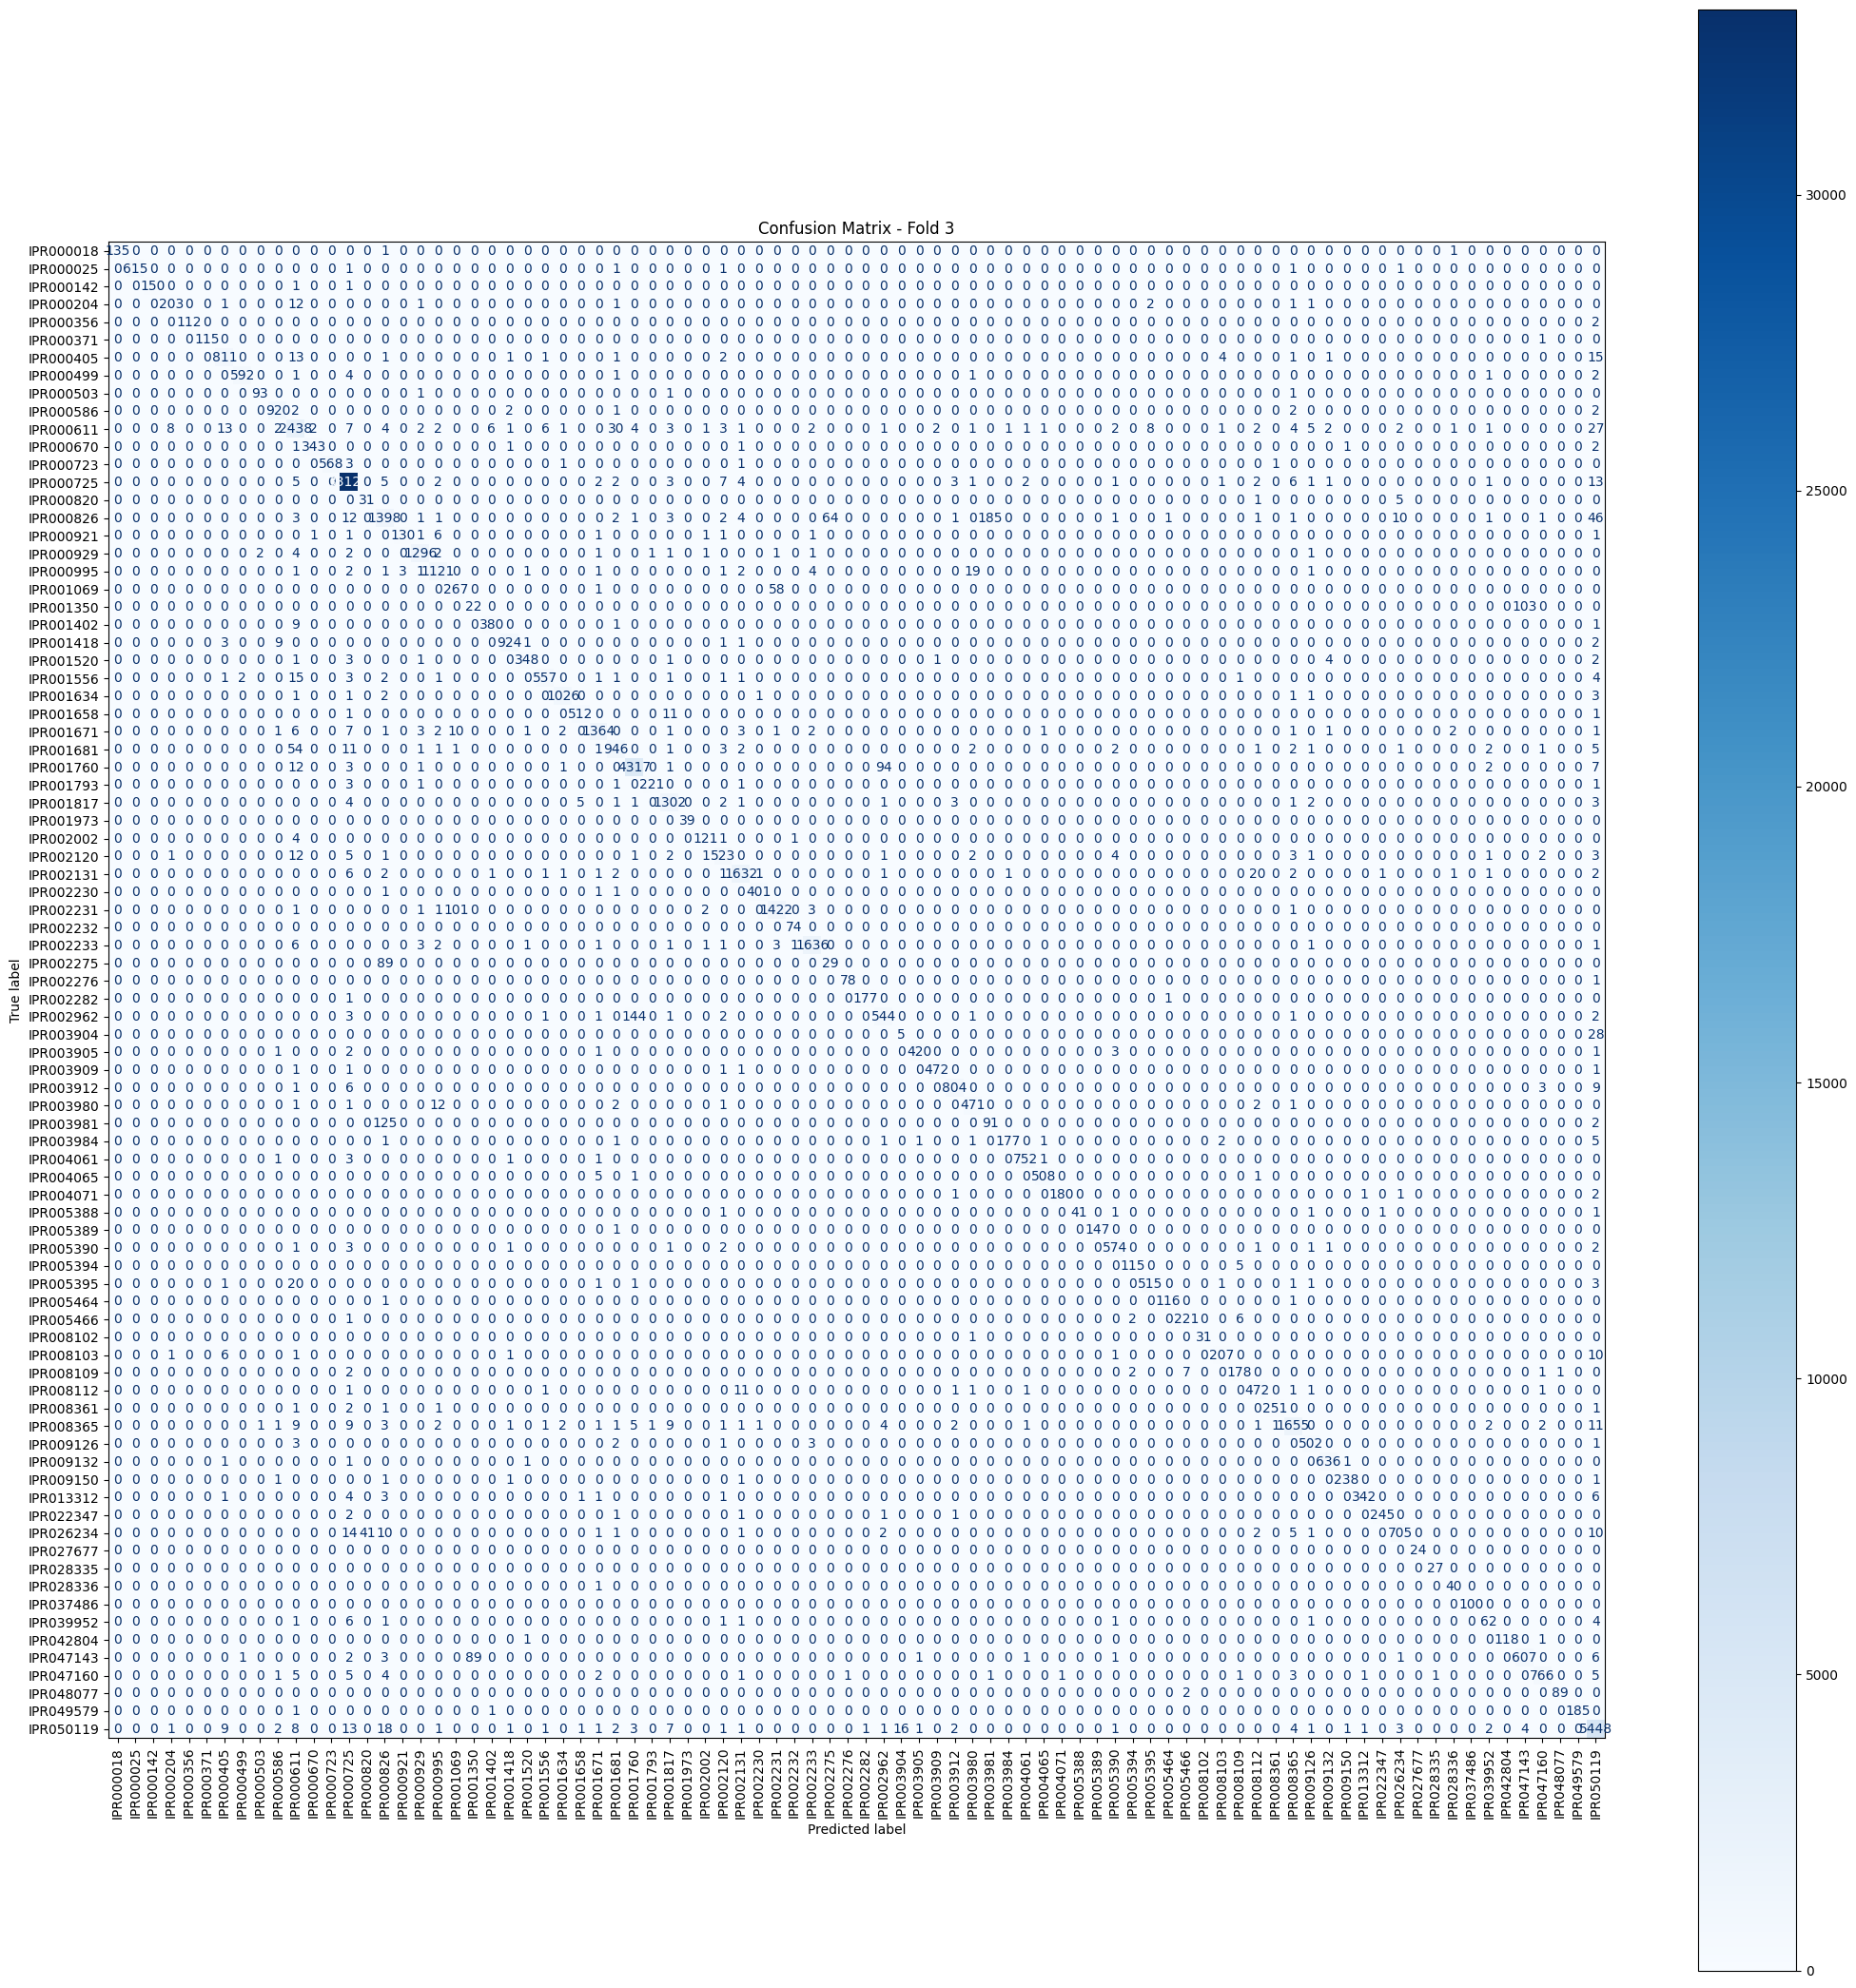

[Fold 4 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_4386/742503592.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.9706 | Precision: 0.9236 | Recall: 0.9172 | F1: 0.9193
              precision    recall  f1-score       support
IPR000018      0.978102  0.978102  0.978102    137.000000
IPR000025      0.987159  0.991935  0.989541    620.000000
IPR000142      1.000000  0.993421  0.996700    152.000000
IPR000204      0.980583  0.909910  0.943925    222.000000
IPR000356      1.000000  0.964912  0.982143    114.000000
...                 ...       ...       ...           ...
IPR049579      1.000000  1.000000  1.000000    187.000000
IPR050119      0.966619  0.974622  0.970604   5556.000000
accuracy       0.970592  0.970592  0.970592      0.970592
macro avg      0.923586  0.917240  0.919326  84196.000000
weighted avg   0.969125  0.970592  0.969711  84196.000000

[87 rows x 4 columns]


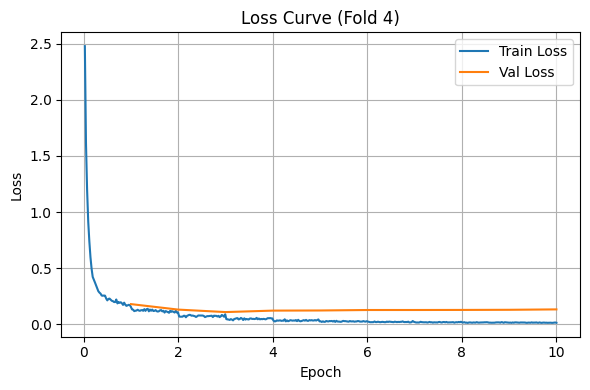

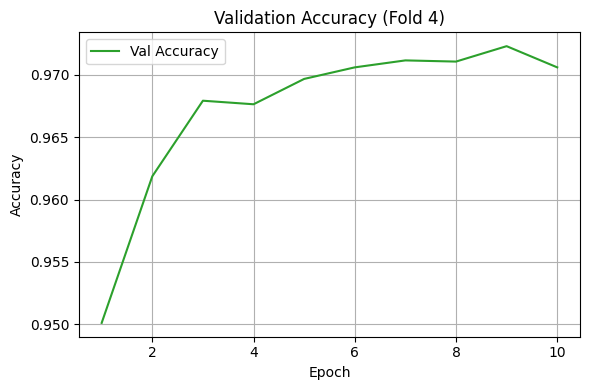

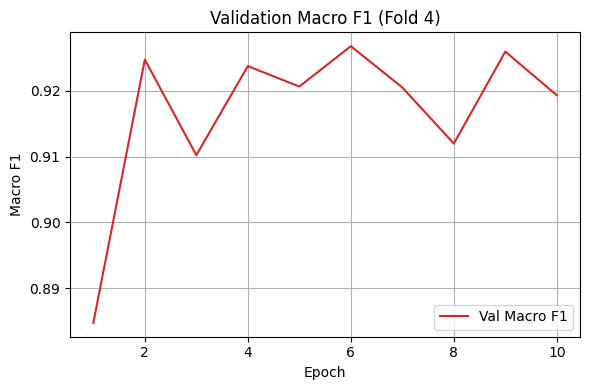

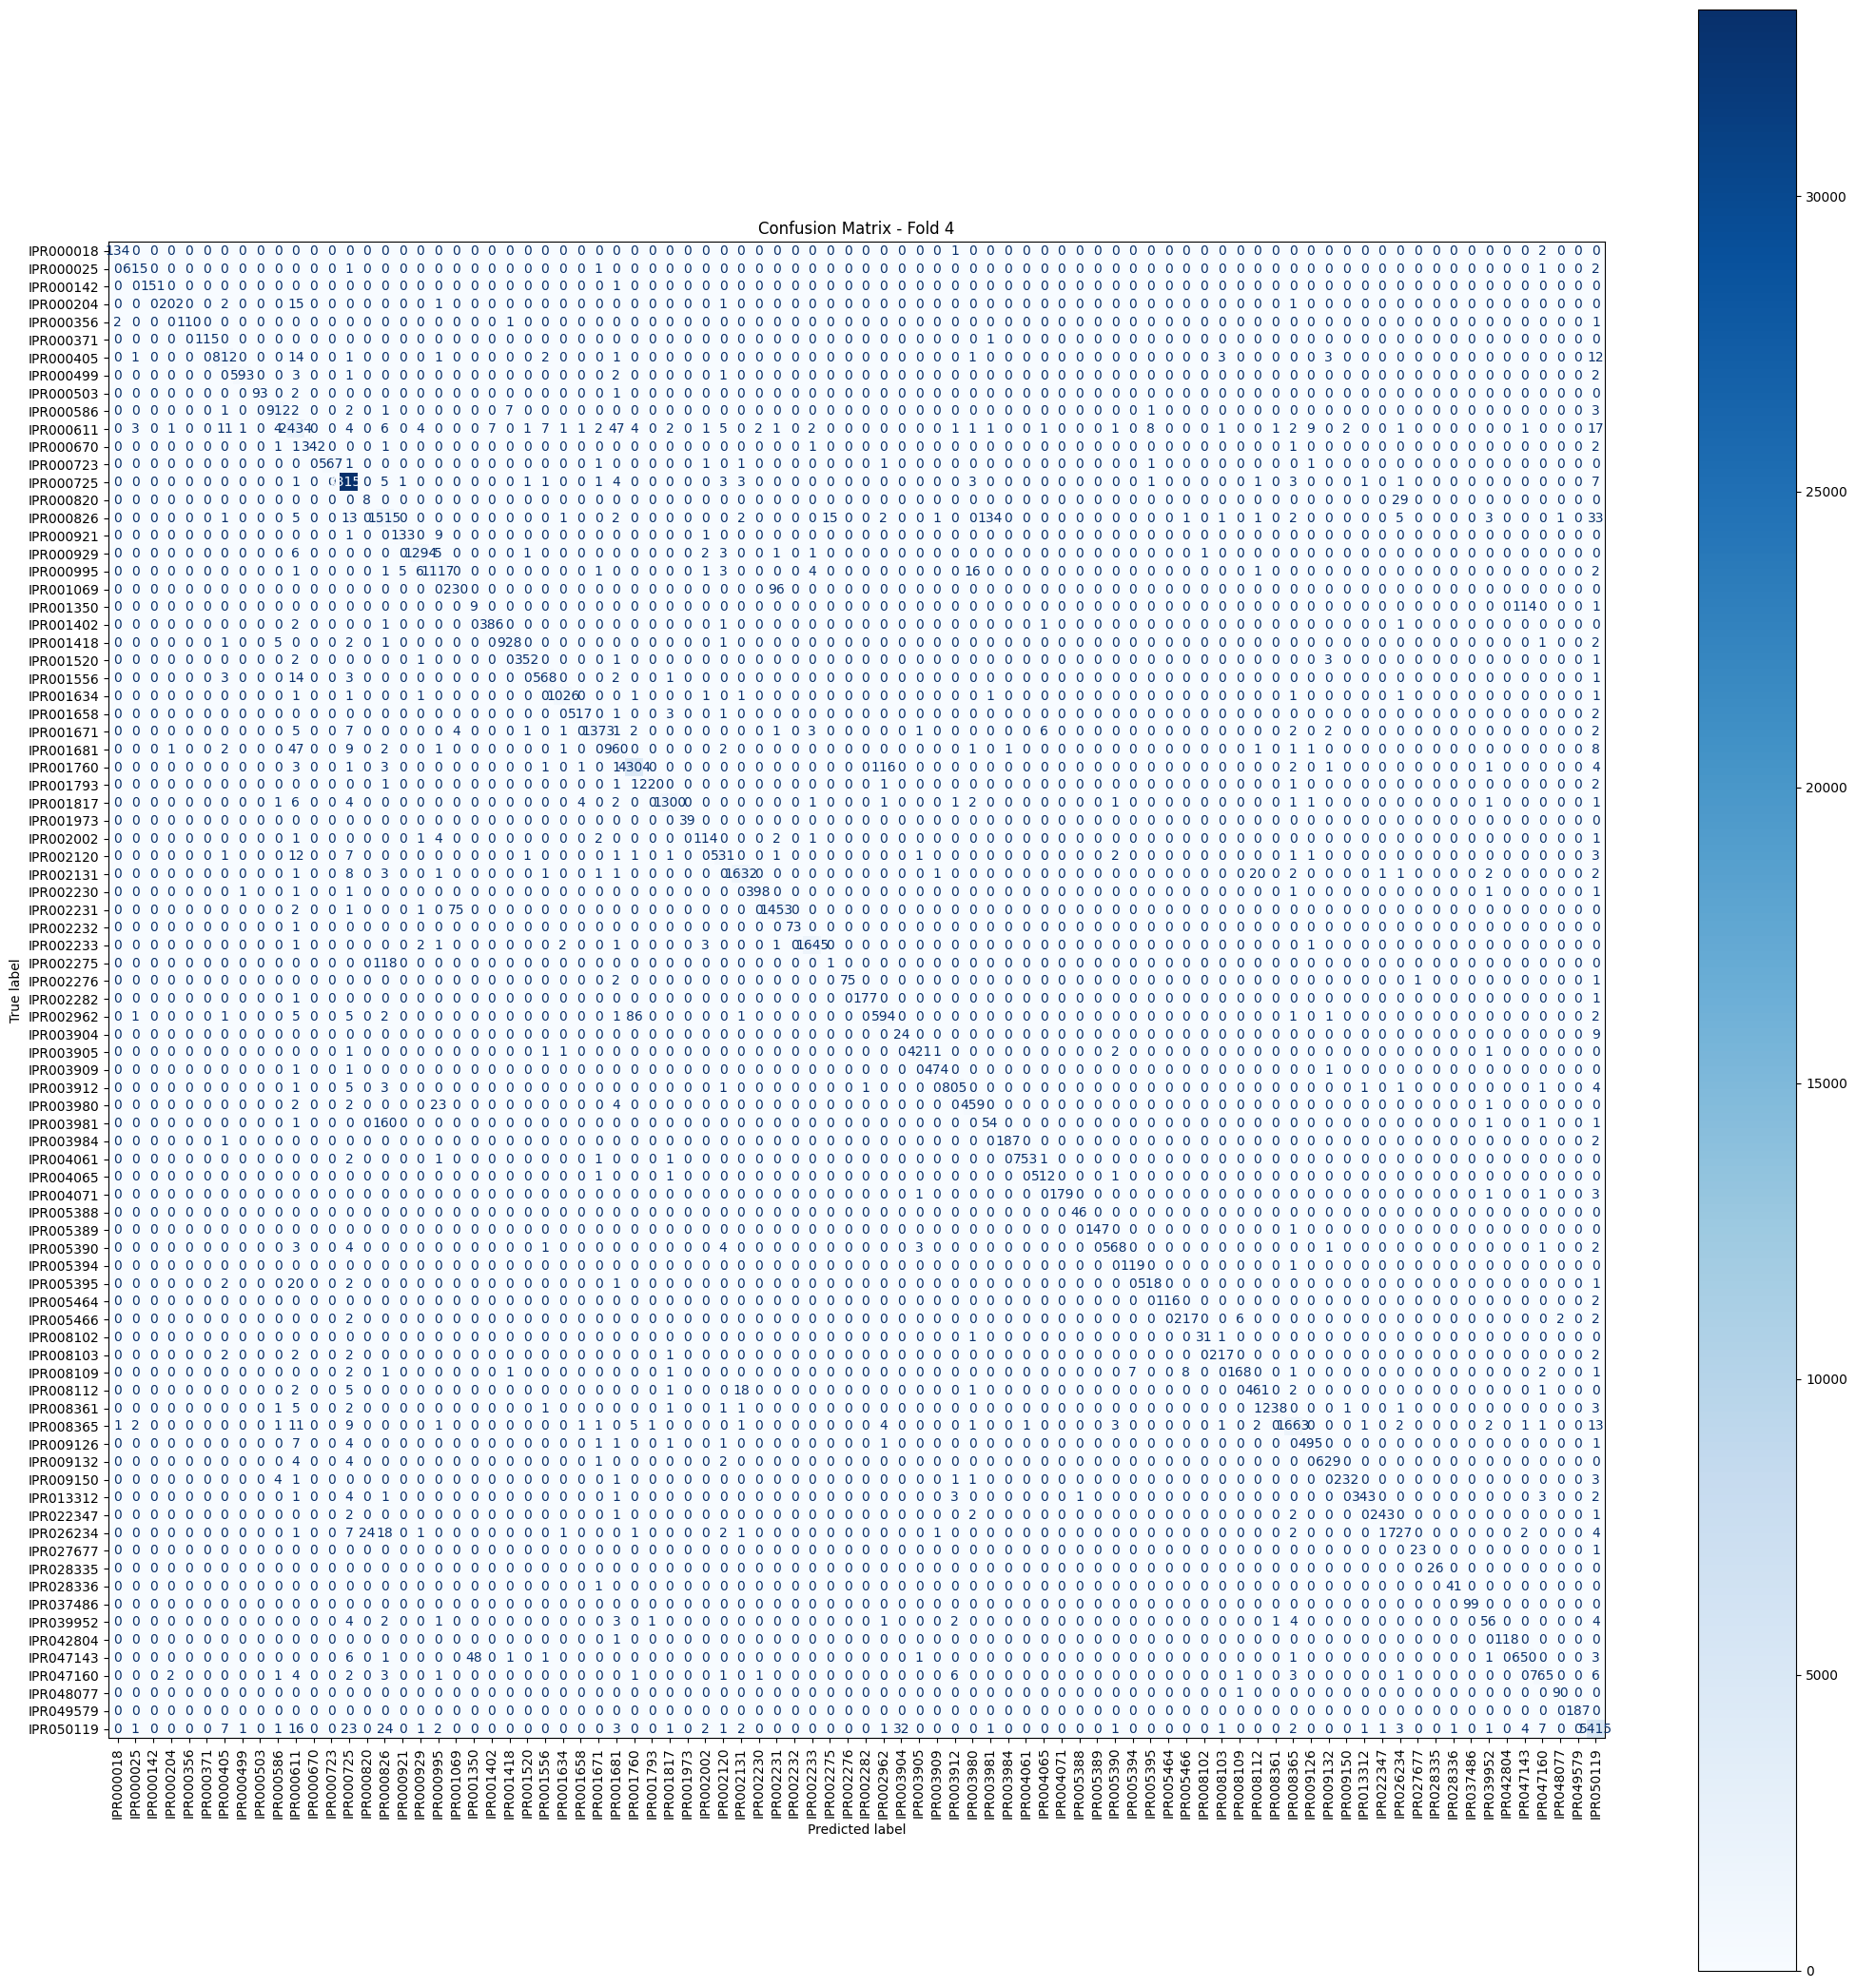

[Fold 5 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_4386/742503592.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Accuracy: 0.9712 | Precision: 0.9235 | Recall: 0.9181 | F1: 0.9195
              precision    recall  f1-score       support
IPR000018      0.971014  0.978102  0.974545    137.000000
IPR000025      0.996732  0.985460  0.991064    619.000000
IPR000142      1.000000  0.993464  0.996721    153.000000
IPR000204      0.985577  0.923423  0.953488    222.000000
IPR000356      1.000000  0.964602  0.981982    113.000000
...                 ...       ...       ...           ...
IPR049579      1.000000  0.994681  0.997333    188.000000
IPR050119      0.966399  0.973182  0.969778   5556.000000
accuracy       0.971198  0.971198  0.971198      0.971198
macro avg      0.923520  0.918148  0.919517  84196.000000
weighted avg   0.969401  0.971198  0.970113  84196.000000

[87 rows x 4 columns]


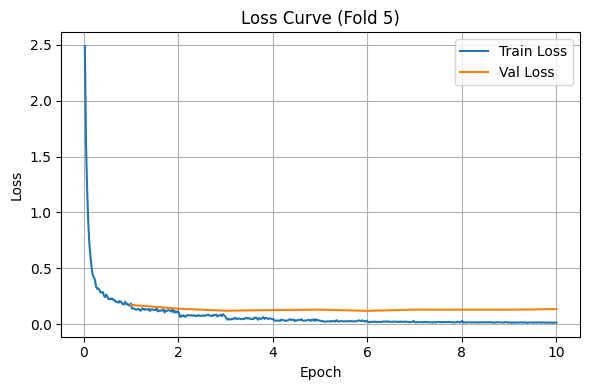

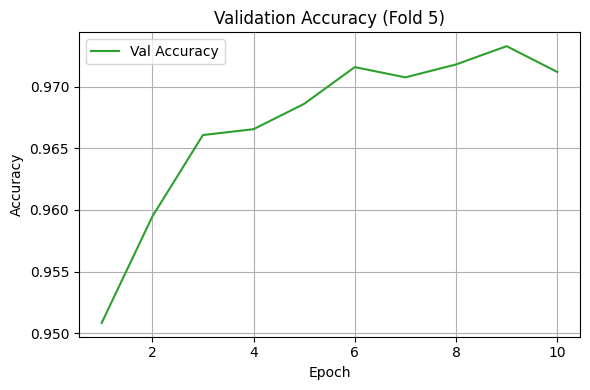

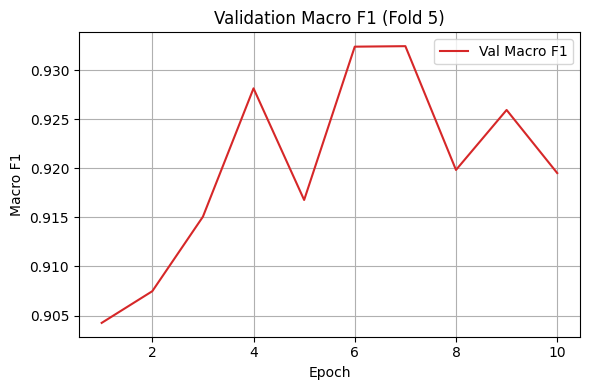

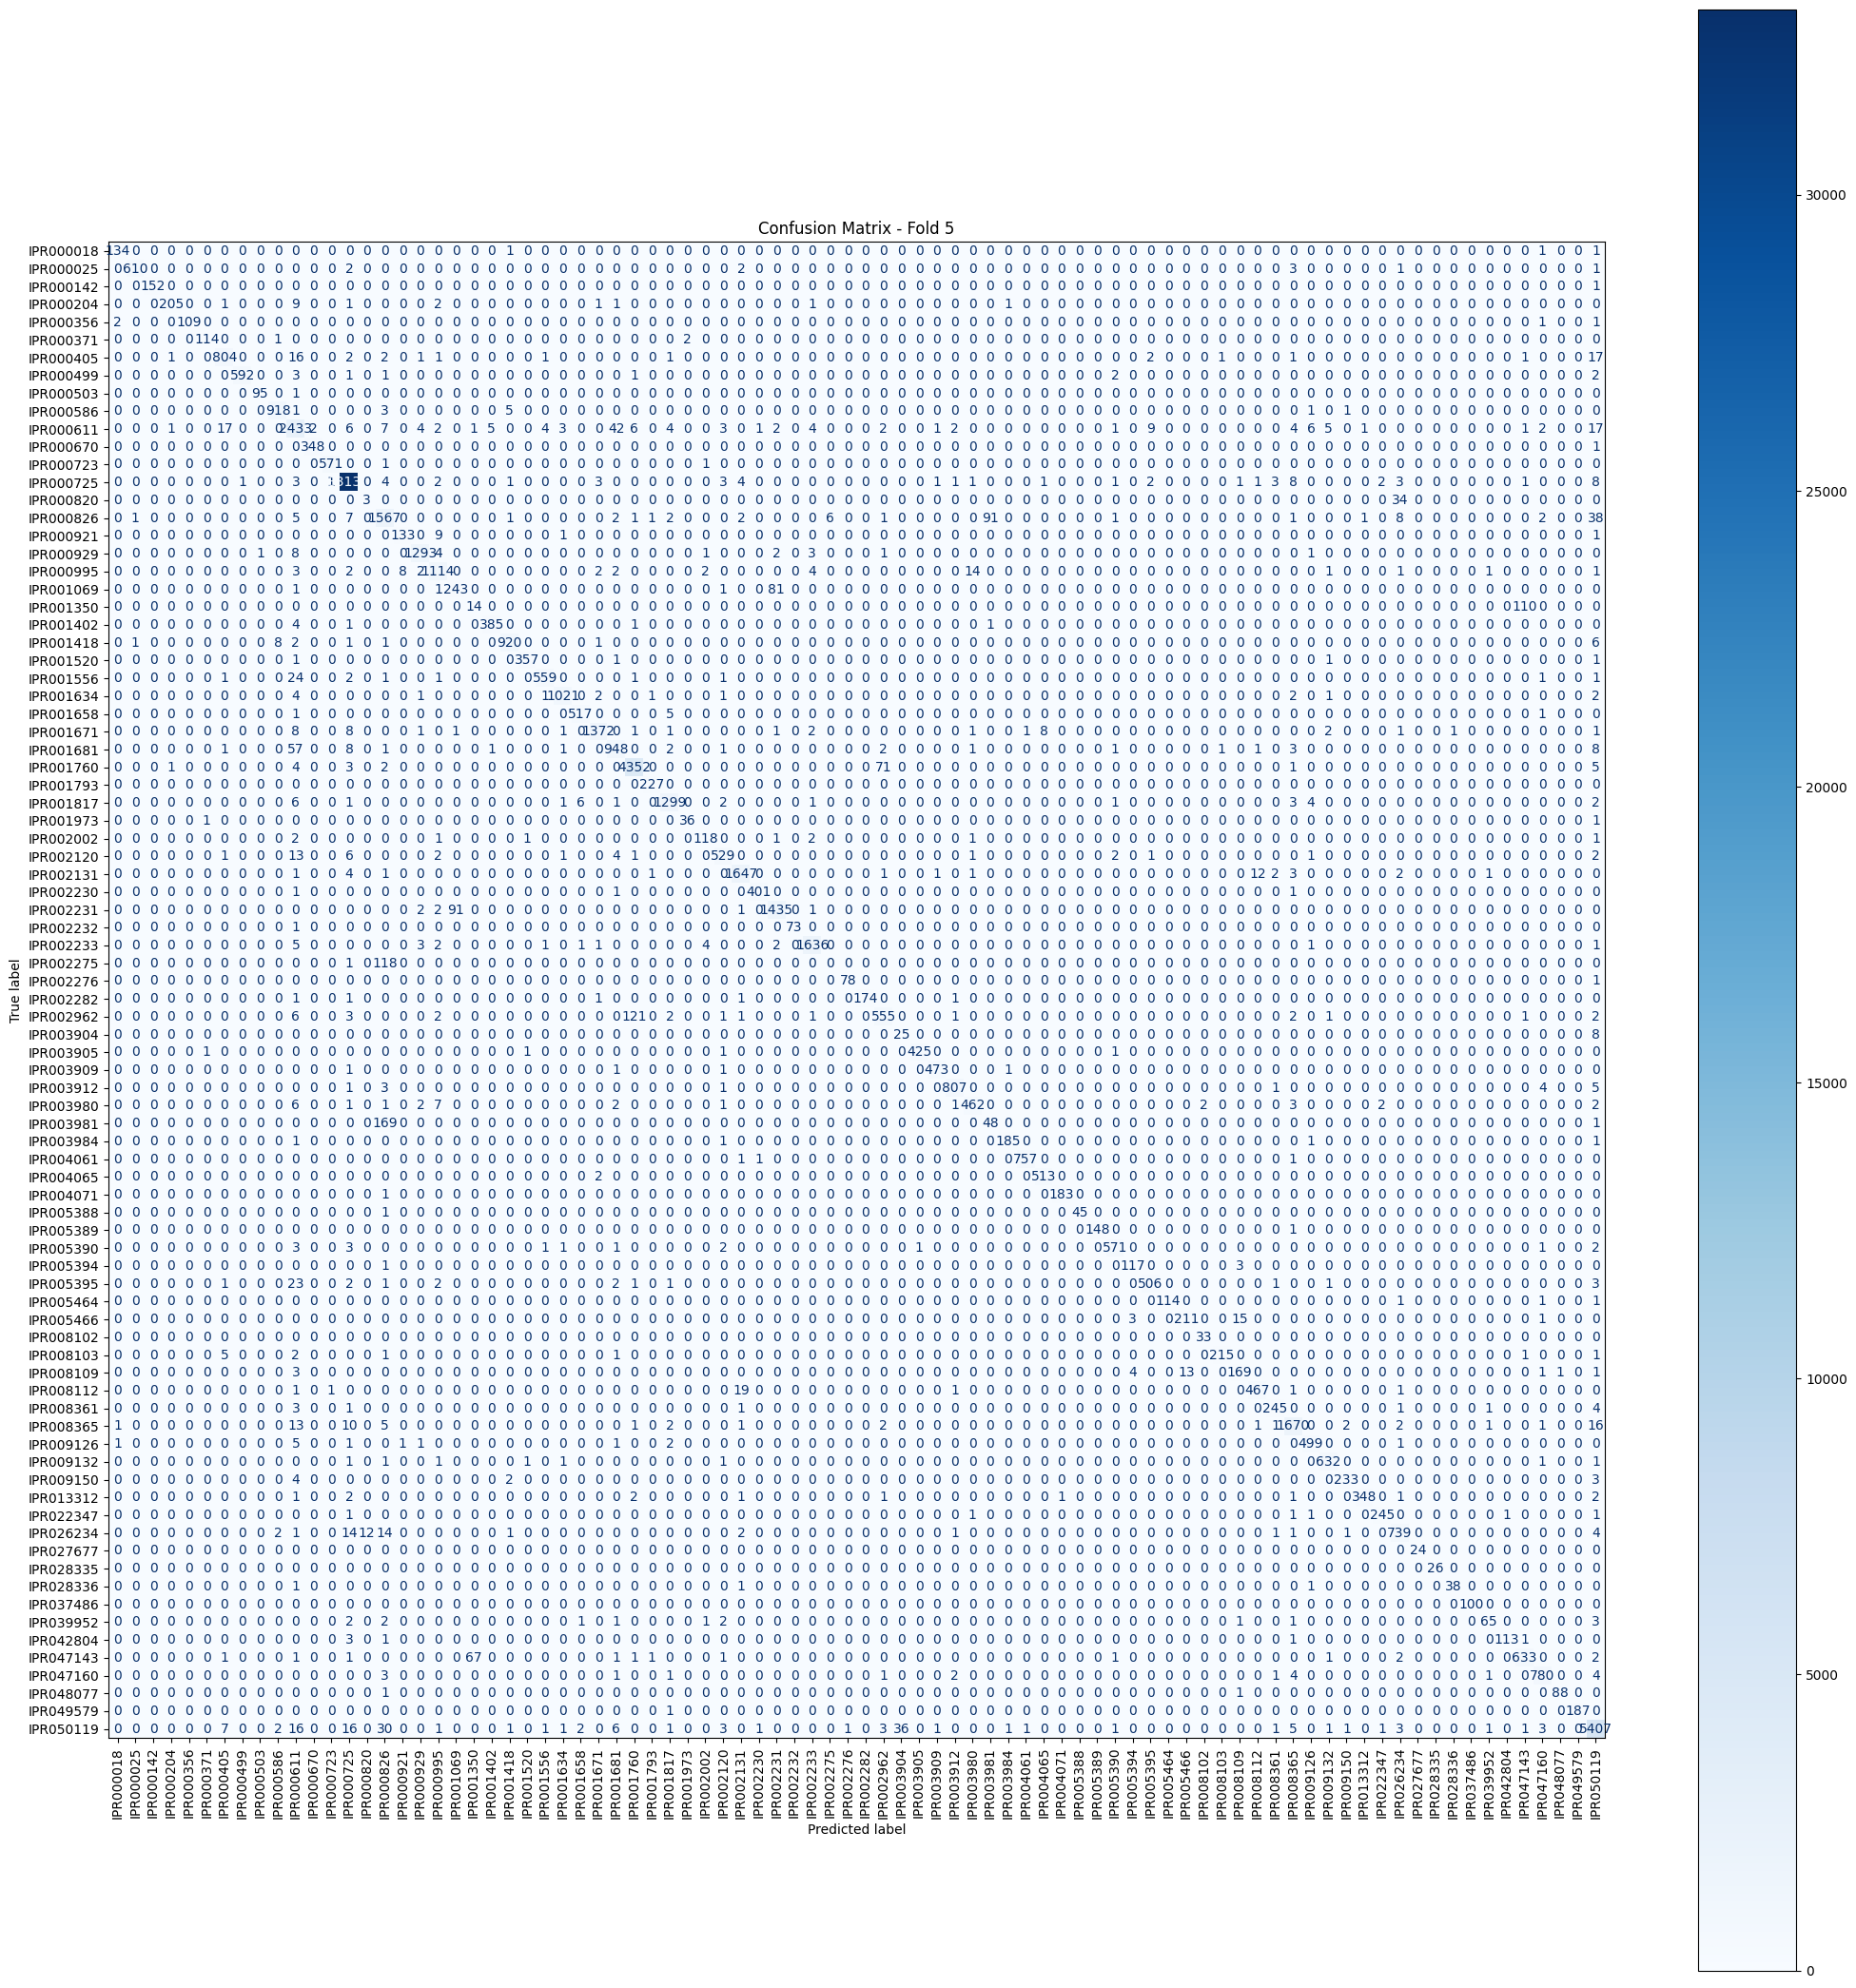

In [5]:
all_accs, all_pres, all_recs, all_f1s = [], [], [], []
all_class_f1s, all_conf_matrices = [], []
all_val_losses, all_val_accs, all_val_f1s = [], [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
    print(f"\033[34m[Fold {fold+1} / 5]\033[0m")

    # Subset 作成
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    # ======================
    # 4. モデル初期化
    # ======================
    model = ViTForImageClassification.from_pretrained(
        MODEL_NAME,
        num_labels=84,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"../models/amino-classification-transformer-vit-interpro-stratified-kfold/batch-{BATCH_SIZE}-epoch-{EPOCHS}-lr-{LR}/{fold+1}",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        eval_strategy="epoch",
        save_strategy="no",
        num_train_epochs=EPOCHS,
        logging_dir="./logs",
        report_to="none",
        learning_rate=LR,
        load_best_model_at_end=False,
        fp16=True,
        dataloader_num_workers=8
    )

    # ======================
    # 5. 評価指標
    # ======================
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
        f1 = f1_score(labels, preds, average="macro")
        pre = precision_score(labels, preds, average="macro", zero_division=0)
        rec = recall_score(labels, preds, average="macro", zero_division=0)
        return {"accuracy": acc, "precision": pre, "recall": rec, "f1": f1}

    # ======================
    # 6. Trainer実行
    # ======================
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=processor,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # ==== ログから学習曲線抽出 ====
    log_history = pd.DataFrame(trainer.state.log_history)
    log_history = log_history.dropna(subset=["epoch"])
    train_loss = log_history[log_history["loss"].notna()][["epoch", "loss"]]
    eval_loss = log_history[log_history["eval_loss"].notna()][["epoch", "eval_loss", "eval_accuracy", "eval_f1"]]

    all_val_losses.append(eval_loss["eval_loss"].values)
    all_val_accs.append(eval_loss["eval_accuracy"].values)
    all_val_f1s.append(eval_loss["eval_f1"].values)

    # ======================
    # 7. 推論と評価
    # ======================
    preds = trainer.predict(val_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    acc = accuracy.compute(predictions=y_pred, references=y_true)["accuracy"]
    pre = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=list(label2id.values()))

    report = classification_report(y_true, y_pred, target_names=list(label2id.keys()), output_dict=True)
    class_f1 = [report[c]["f1-score"] for c in list(label2id.keys())]

    # ==== 保存 ====
    all_accs.append(acc)
    all_pres.append(pre)
    all_recs.append(rec)
    all_f1s.append(f1)
    all_class_f1s.append(class_f1)
    all_conf_matrices.append(cm)

    # ==== 表示 ====
    print(f"\033[91mAccuracy: {acc:.4f}\033[0m | "
          f"\033[92mPrecision: {pre:.4f}\033[0m | "
          f"\033[93mRecall: {rec:.4f}\033[0m | "
          f"\033[94mF1: {f1:.4f}\033[0m")
    print(pd.DataFrame(report).T)

    # ==== foldごとの学習曲線を可視化 ====
    # --- Loss 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_loss["epoch"], train_loss["loss"], label="Train Loss", color="C0")
    plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Val Loss", color="C1")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Accuracy 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(eval_loss["epoch"], eval_loss["eval_accuracy"], label="Val Accuracy", color="C2")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Validation Accuracy (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Macro F1 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(eval_loss["epoch"], eval_loss["eval_f1"], label="Val Macro F1", color="C3")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title(f"Validation Macro F1 (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # クラス数を取得
    n_classes = len(label2id)
    
    # サイズスケーリング係数
    scale = 0.25
    figsize = (n_classes * scale, n_classes * scale)
    
    # 図を作成
    plt.figure(figsize=figsize)
    
    # 混同行列を可視化
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
    disp.plot(cmap="Blues", xticks_rotation=90, ax=plt.gca())  # xticks_rotationでラベルの重なり防止
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    
    plt.tight_layout()  # レイアウトを自動調整
    plt.show()

## 4. 平均可視化

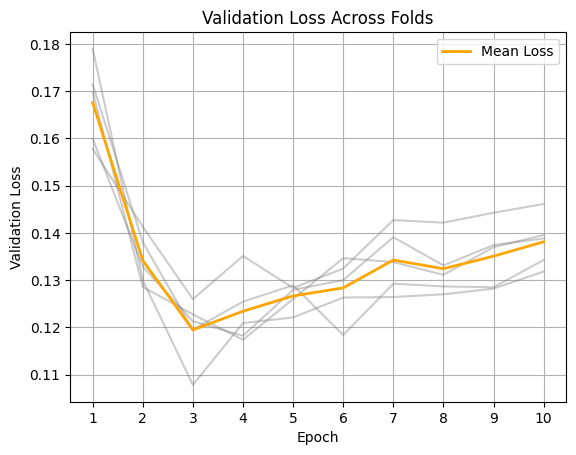

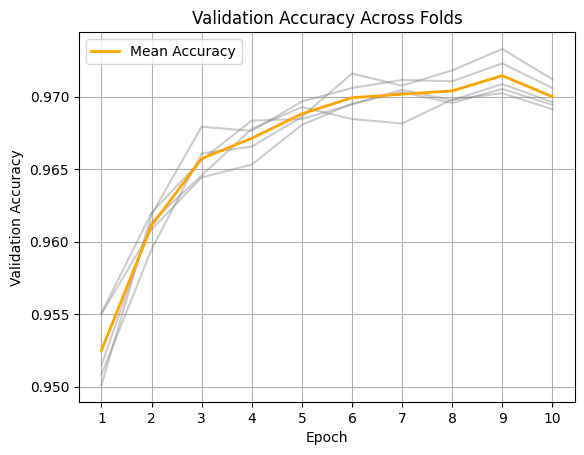

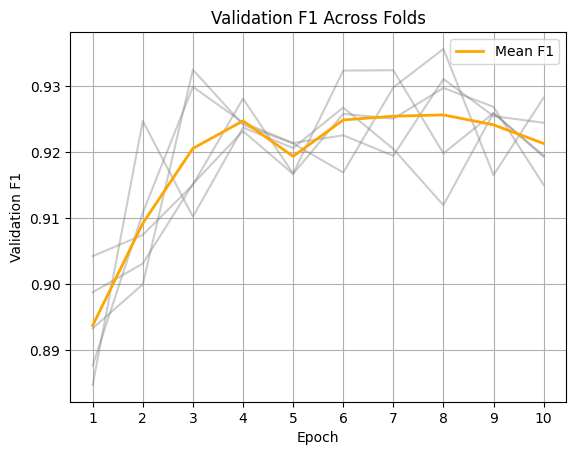

In [6]:
epochs = np.arange(1, EPOCHS + 1)

def interp_to_epochs(arr):
    arr = np.asarray(arr)
    orig_x = np.arange(1, len(arr) + 1)

    if len(arr) == 1:
        return np.full_like(epochs, arr[0], dtype=float)

    return np.interp(epochs, orig_x, arr)

def plot_mean_curves(all_vals, y_label, title, metric_name):
    interp_vals = []

    for v in all_vals:
        v_interp = interp_to_epochs(v)
        interp_vals.append(v_interp)
        plt.plot(epochs, v_interp, color="gray", alpha=0.4)

    interp_vals = np.vstack(interp_vals)
    mean_vals = interp_vals.mean(axis=0)

    plt.plot(epochs, mean_vals, color="orange", linewidth=2, label=f"Mean {metric_name}")
    plt.xlabel("Epoch"); plt.ylabel(y_label); plt.title(title)
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)
    plt.show()

plot_mean_curves(all_val_losses, "Validation Loss", "Validation Loss Across Folds", "Loss")
plot_mean_curves(all_val_accs, "Validation Accuracy", "Validation Accuracy Across Folds", "Accuracy")
plot_mean_curves(all_val_f1s, "Validation F1", "Validation F1 Across Folds", "F1")

## 5. 総合評価


===== Average Across 5 Folds =====
Accuracy : 0.9700
Precision: 0.9256
Recall   : 0.9194
F1       : 0.9213

Per-Class F1 (Macro Average):
  IPR000018: 0.9779
  IPR000025: 0.9909
  IPR000142: 0.9954
  IPR000204: 0.9388
  IPR000356: 0.9831
  IPR000371: 0.9905
  IPR000405: 0.9538
  IPR000499: 0.9897
  IPR000503: 0.9802
  IPR000586: 0.9837
  IPR000611: 0.9214
  IPR000670: 0.9911
  IPR000723: 0.9948
  IPR000725: 0.9968
  IPR000820: 0.3113
  IPR000826: 0.8328
  IPR000921: 0.9273
  IPR000929: 0.9845
  IPR000995: 0.9609
  IPR001069: 0.7360
  IPR001350: 0.2124
  IPR001402: 0.9813
  IPR001418: 0.9845
  IPR001520: 0.9821
  IPR001556: 0.9668
  IPR001634: 0.9903
  IPR001658: 0.9836
  IPR001671: 0.9794
  IPR001681: 0.9232
  IPR001760: 0.9721
  IPR001793: 0.9889
  IPR001817: 0.9780
  IPR001973: 0.9815
  IPR002002: 0.9157
  IPR002120: 0.9380
  IPR002131: 0.9751
  IPR002230: 0.9904
  IPR002231: 0.9416
  IPR002232: 0.9906
  IPR002233: 0.9893
  IPR002275: 0.2068
  IPR002276: 0.9846
  IPR002282: 0.9864
 

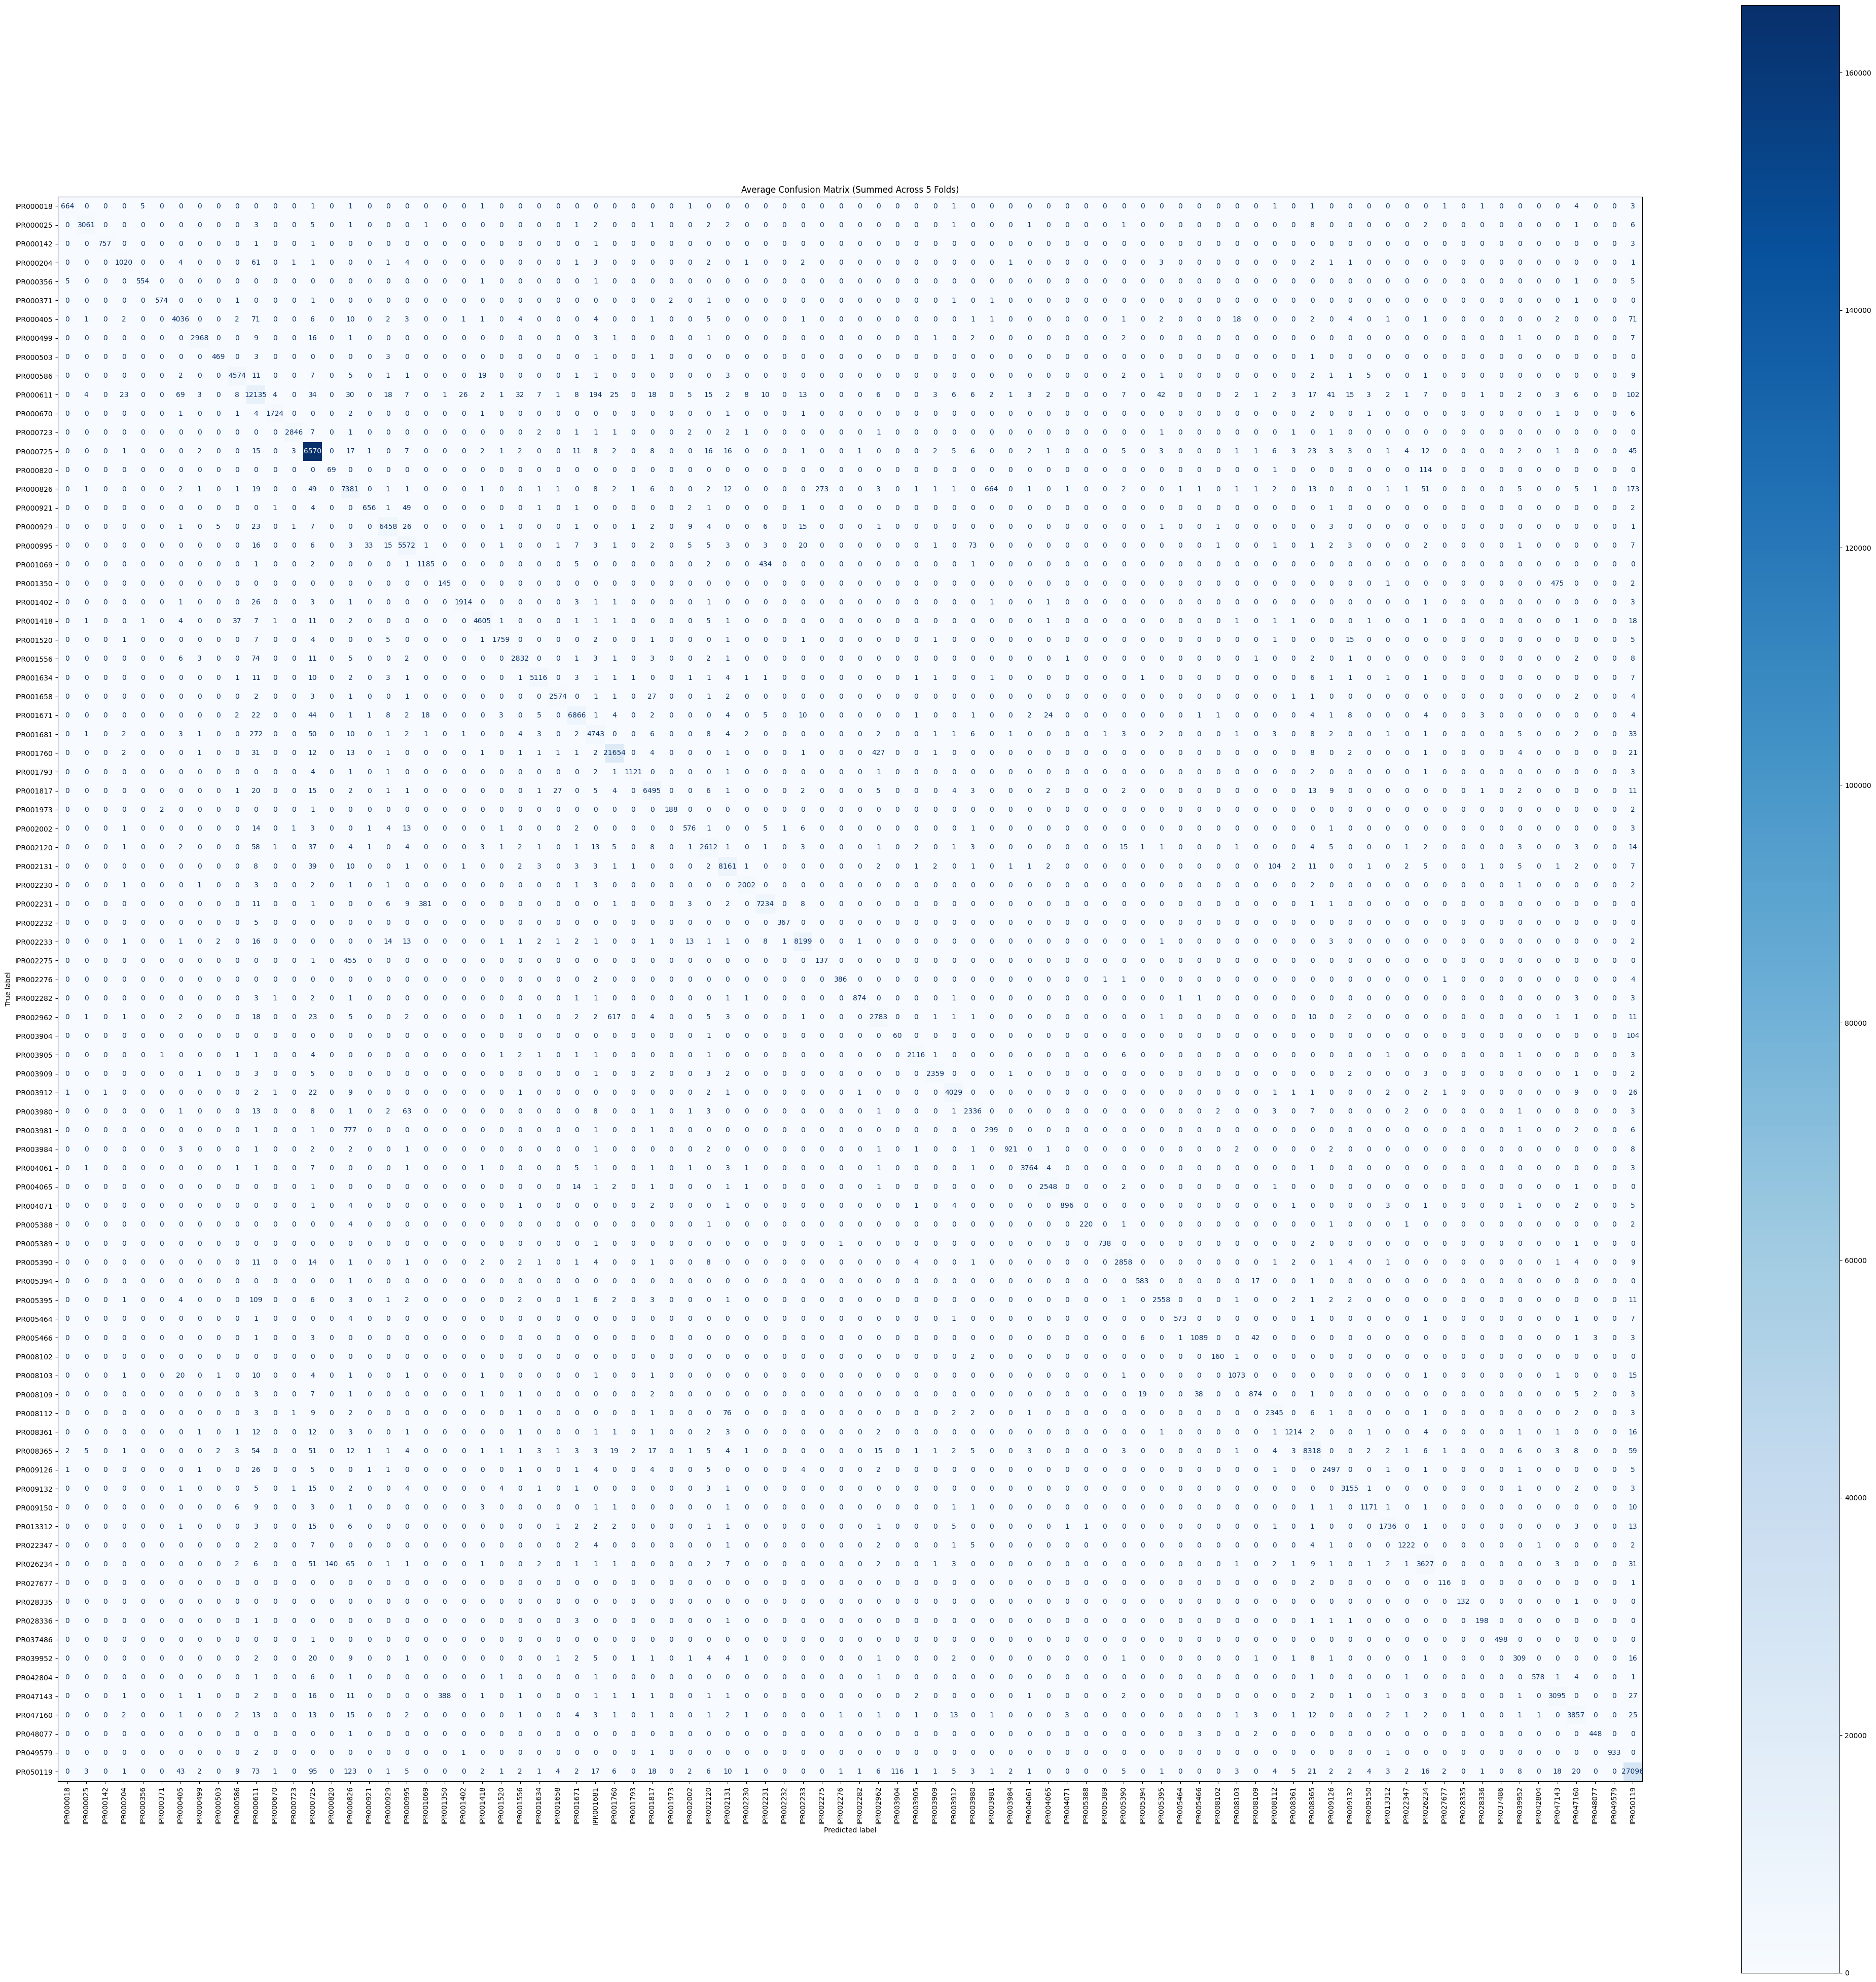

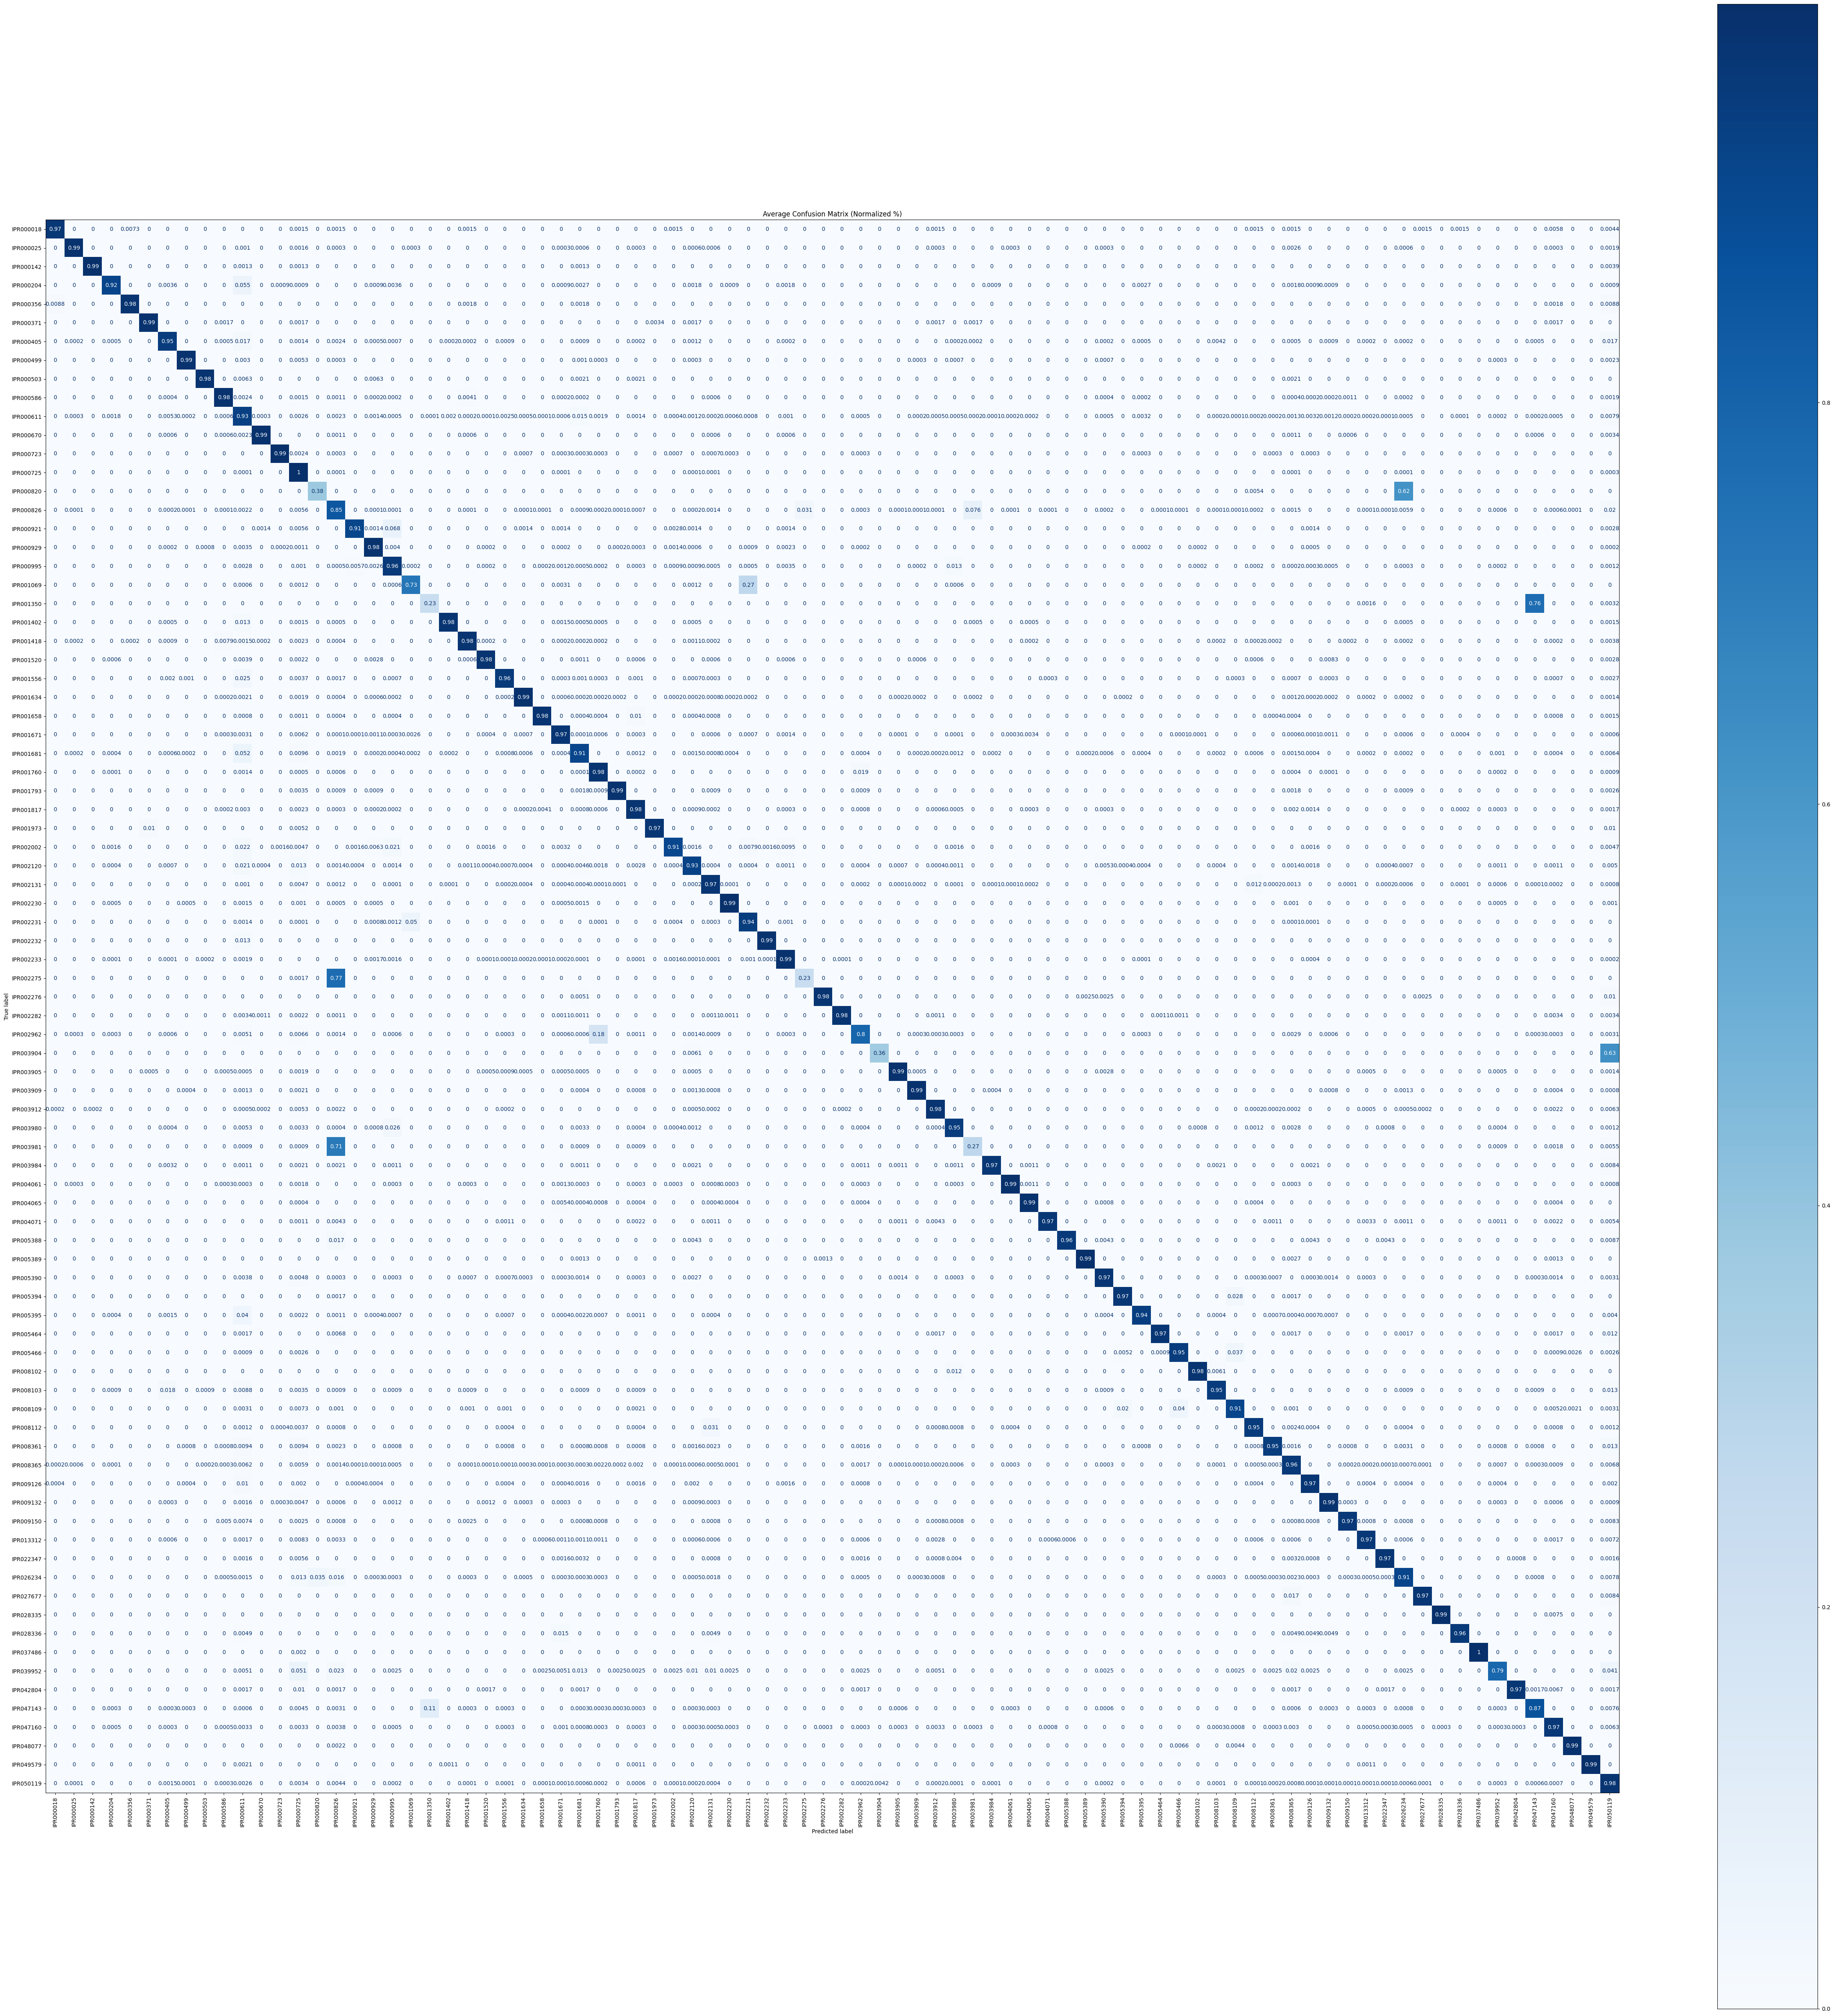

In [12]:
mean_acc = np.mean(all_accs)
mean_pre = np.mean(all_pres)
mean_rec = np.mean(all_recs)
mean_f1 = np.mean(all_f1s)
mean_class_f1 = np.mean(np.array(all_class_f1s), axis=0)

print("\n\033[36m===== Average Across 5 Folds =====\033[0m")
print(f"Accuracy : {mean_acc:.4f}")
print(f"Precision: {mean_pre:.4f}")
print(f"Recall   : {mean_rec:.4f}")
print(f"F1       : {mean_f1:.4f}\n")

print("Per-Class F1 (Macro Average):")
for cls, score in zip(label2id.keys(), mean_class_f1):
    print(f"  {cls}: {score:.4f}")

# クラス数を取得
n_classes = len(label2id)

# サイズスケーリング係数
scale = 0.6
figsize = (max(10, n_classes * scale), max(10, n_classes * scale))

# ==== 混同行列平均表示 ====
mean_cm = np.sum(all_conf_matrices, axis=0)
plt.figure(figsize=figsize)
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels=list(label2id.keys()))
disp.plot(cmap="Blues", xticks_rotation=90, ax=plt.gca(), colorbar=True)
plt.title("Average Confusion Matrix (Summed Across 5 Folds)")
plt.show()

# --- 割合ベース混同行列（行ごとに正規化） ---
mean_cm_normalized = mean_cm.astype('float') / mean_cm.sum(axis=1, keepdims=True)
mean_cm_normalized = np.nan_to_num(mean_cm_normalized)  # NaN防止
mean_cm_normalized = np.round(mean_cm_normalized, 4)

plt.figure(figsize=figsize)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=mean_cm_normalized, display_labels=list(label2id.keys()))
disp_norm.plot(cmap="Blues", xticks_rotation=90, ax=plt.gca(), colorbar=True)
plt.title("Average Confusion Matrix (Normalized %)")
plt.tight_layout()
plt.show()